In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nodepy import rk, stability_function

rk4 = rk.loadRKM('RK44').__num__()
rk4x2 = rk4*rk4
ssp2 = rk.loadRKM('SSP22').__num__()
ssp3 = rk.loadRKM('SSP33').__num__()
ssp104 = rk.loadRKM('SSP104').__num__()
merson4 = rk.loadRKM('Merson43').__num__()
bs5 = rk.loadRKM('BS5').__num__()

trbdf = rk.loadRKM('TR-BDF2').__num__()
be = rk.loadRKM('BE').__num__()
irk2 = rk.loadRKM('LobattoIIIA2').__num__()

In [2]:
def RRK_pos(rkm, dt, f, w0=[1.,0], t_final=1., relaxation=True, 
        rescale_step=True, debug=False, gammatol=10.1, print_gamma=False,
        one_step=False):
    """
    Relaxation Runge-Kutta method implementation.
    
    Options:
    
        rkm: Base Runge-Kutta method, in Nodepy format
        dt: time step size
        f: RHS of ODE system
        w0: Initial data
        t_final: final solution time
        relaxation: if True, use relaxation method.  Otherwise, use vanilla RK method.
        rescale_step: if True, new time step is t_n + \gamma dt
        debug: output some additional diagnostics
        gammatol: Fail if abs(1-gamma) exceeds this value
        
    """
    w = np.array(w0)
    t = 0
    # We pre-allocate extra space because if rescale_step==True then
    # we don't know exactly how many steps we will take.
    ww = np.zeros([len(w0),int((t_final-t)/dt*2.5)+10000])
    ww[:,0] = w.copy()
    tt = [t]
    ii = 0
    s = len(rkm)
    b = rkm.b
    y = np.zeros((s,len(w0)))
    max_gammam1 = 0.
    gams = []
    
    while t < t_final:
        if t + dt >= t_final:
            dt = t_final - t # Hit final time exactly
        
        for i in range(s):
            y[i,:] = w.copy()
            for j in range(i):
                y[i,:] += rkm.A[i,j]*dt*f(y[j,:])
                
        F = np.array([f(y[i,:]) for i in range(s)])
        dw = dt*sum([b[j]*F[j] for j in range(s)])
        
        eps = 1.e-10
        gam = 1.
        if relaxation:
            wnp1 = w + dw
            neg = np.nonzero(wnp1<-eps)[0]
            if len(neg)>0:
                for ind in neg:
                    #print(ind,w[ind],dw[ind])
                    gam_ind = w[ind]/(w[ind]-wnp1[ind])
                    gam = min(gam, gam_ind)
            if gam!=1: print('gam: ',gam)
            w = w + gam*dw

        else:  # Use standard RK method
            w = w + dw
           
        if print_gamma:
            print(gam)
        
        if np.abs(gam-1.) > gammatol:
            print(gam)
            raise Exception("The time step is probably too large.")
            
        if gam == 0:
            raise Exception("gamma=0")
        
        if (t+dt < t_final) and rescale_step:
            t += gam*dt
        else:
            t += dt
        ii += 1
        tt.append(t)
        ww[:,ii] = w.copy()
        if debug:
            gm1 = np.abs(1.-gam)
            max_gammam1 = max(max_gammam1,gm1)
            gams.append(gam)
            
        if one_step:
            return w, gam
            
    if debug:
        print(max_gammam1)
        return tt, ww[:, :ii+1], np.array(gams)
    else:
        return tt, ww[:,:ii+1]

In [3]:
def f2(u):
    return -u**2

gam:  0.9191176470588235


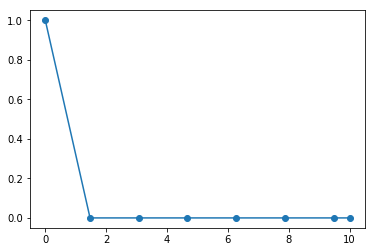

In [4]:
u0 = np.array([1.])
tt, uu = RRK_pos(ssp2,dt=1.6,f=f2,w0=u0,t_final=10.,relaxation=True)

uu=uu.squeeze()
plt.plot(tt,uu,'-o')

In [5]:
N=50
x = np.linspace(0,1,N)
dx = x[1]-x[0]

def f_heat(u):
    du = np.zeros_like(u)
    du[1:-1] = (u[2:]-2*u[1:-1]+u[:-2])
    du[0] = -2*u[0]+u[1]
    du[-1] = u[-2]-2*u[-1]
    return du/dx**2

u0 = (x>0.5)+0.1
dt = 0.7*dx**2

tt, uu = RRK_pos(ssp3,dt=dt,f=f_heat,w0=u0,t_final=1.1,relaxation=True)
print(np.min(uu))

gam:  0.9237295342354451
gam:  0.8179292769613276
gam:  0.840968805856145
gam:  0.8071150395029979
gam:  0.8035036627437464
gam:  0.8242487291239718
gam:  0.7975851952275211
gam:  0.8025684816724278
gam:  0.8175888515832218
gam:  0.7894888071808407
gam:  0.8052258206108879
gam:  0.8022414941645591
gam:  0.7947142834729364
gam:  0.809110289918417
gam:  0.7899140456668963
gam:  0.8001192500131498
gam:  0.7989373424774489
gam:  0.7933468186677953
gam:  0.8052814168161778
gam:  0.7881637373124094
gam:  0.7989244684070947
gam:  0.794599197808599
gam:  0.7938086479618771
gam:  0.7995441359048348
gam:  0.7896559693780341
gam:  0.7987561922634546
gam:  0.7907232894261816
gam:  0.7945170166839546
gam:  0.7949436592067539
gam:  0.7909380665748094
gam:  0.7984000179099723
gam:  0.787899716160093
gam:  0.7947944468530337
gam:  0.7916036622598953
gam:  0.7916040398071886
gam:  0.7948179505460717
gam:  0.7888331580125972
gam:  0.794392538317115
gam:  0.7895231294019772
gam:  0.7915321801557017
gam: 

gam:  0.7891351425261208
gam:  0.7887559619496836
gam:  0.7891298860694018
gam:  0.78875573496927
gam:  0.789124702739395
gam:  0.7887555109527848
gam:  0.7891195914372046
gam:  0.7887552898603616
gam:  0.7891145510822691
gam:  0.7887550716526889
gam:  0.7891095806120174
gam:  0.7887548562910043
gam:  0.7891046789815339
gam:  0.7887546437370855
gam:  0.7890998451632278
gam:  0.7887544339532424
gam:  0.7890950781465096
gam:  0.7887542269023115
gam:  0.7890903769374752
gam:  0.788754022547646
gam:  0.7890857405585985
gam:  0.7887538208531097
gam:  0.7890811680484244
gam:  0.7887536217830702
gam:  0.7890766584612743
gam:  0.7887534253023899
gam:  0.789072210866955
gam:  0.7887532313764215
gam:  0.7890678243504735
gam:  0.7887530399709984
gam:  0.789063498011756
gam:  0.7887528510524295
gam:  0.7890592309653783
gam:  0.7887526645874914
gam:  0.7890550223402946
gam:  0.7887524805434234
gam:  0.7890508712795757
gam:  0.7887522988879176
gam:  0.7890467769401548
gam:  0.7887521195891156
gam:  

gam:  0.7887590816792324
gam:  0.7887391968796297
gam:  0.7887588209916535
gam:  0.7887391848777808
gam:  0.7887585635768292
gam:  0.7887391730261296
gam:  0.7887583093933627
gam:  0.7887391613227877
gam:  0.7887580584003875
gam:  0.7887391497658925
gam:  0.7887578105575613
gam:  0.7887391383536033
gam:  0.7887575658250594
gam:  0.7887391270841043
gam:  0.788757324163566
gam:  0.7887391159556012
gam:  0.7887570855342725
gam:  0.7887391049663236
gam:  0.7887568498988635
gam:  0.7887390941145219
gam:  0.7887566172195174
gam:  0.7887390833984705
gam:  0.7887563874588934
gam:  0.7887390728164652
gam:  0.7887561605801319
gam:  0.7887390623668216
gam:  0.7887559365468437
gam:  0.788739052047879
gam:  0.788755715323104
gam:  0.7887390418579957
gam:  0.7887554968734476
gam:  0.7887390317955528
gam:  0.7887552811628631
gam:  0.7887390218589498
gam:  0.7887550681567866
gam:  0.7887390120466078
gam:  0.7887548578210957
gam:  0.788739002356967
gam:  0.7887546501221016
gam:  0.7887389927884881
gam:

gam:  0.7887383374179409
gam:  0.7887404117565772
gam:  0.7887383361505069
gam:  0.7887403846427294
gam:  0.788738334898868
gam:  0.788740357866866
gam:  0.7887383336628278
gam:  0.7887403314247714
gam:  0.7887383324421912
gam:  0.7887403053122802
gam:  0.7887383312367657
gam:  0.7887402795252823
gam:  0.7887383300463626
gam:  0.7887402540597146
gam:  0.788738328870794
gam:  0.7887402289115699
gam:  0.788738327709875
gam:  0.7887402040768867
gam:  0.7887383265634231
gam:  0.7887401795517548
gam:  0.7887383254312577
gam:  0.7887401553323139
gam:  0.7887383243132008
gam:  0.7887401314147496
gam:  0.7887383232090766
gam:  0.7887401077952972
gam:  0.7887383221187113
gam:  0.7887400844702371
gam:  0.788738321041933
gam:  0.7887400614358994
gam:  0.7887383199785732
gam:  0.7887400386886547
gam:  0.7887383189284635
gam:  0.788740016224925
gam:  0.7887383178914396
gam:  0.7887399940411729
gam:  0.7887383168673376
gam:  0.7887399721339067
gam:  0.788738315855997
gam:  0.7887399504996779
gam:  0

gam:  0.7887383864010303
gam:  0.788738242644689
gam:  0.7887383845238899
gam:  0.7887382425580167
gam:  0.7887383826701302
gam:  0.788738242472424
gam:  0.7887383808394595
gam:  0.788738242387897
gam:  0.7887383790315897
gam:  0.7887382423044234
gam:  0.788738377246238
gam:  0.788738242221989
gam:  0.788738375483123
gam:  0.7887382421405815
gam:  0.7887383737419681
gam:  0.7887382420601879
gam:  0.7887383720224993
gam:  0.7887382419807957
gam:  0.7887383703244472
gam:  0.7887382419023922
gam:  0.7887383686475443
gam:  0.7887382418249652
gam:  0.788738366991528
gam:  0.7887382417485027
gam:  0.7887383653561374
gam:  0.7887382416729924
gam:  0.7887383637411156
gam:  0.7887382415984224
gam:  0.7887383621462095
gam:  0.7887382415247817
gam:  0.7887383605711678
gam:  0.7887382414520578
gam:  0.7887383590157441
gam:  0.7887382413802398
gam:  0.7887383574796928
gam:  0.7887382413093164
gam:  0.7887383559627733
gam:  0.7887382412392763
gam:  0.788738354464747
gam:  0.7887382411701087
gam:  0.

gam:  0.788738242336438
gam:  0.7887382359928258
gam:  0.7887382422536064
gam:  0.788738235989001
gam:  0.7887382421718075
gam:  0.7887382359852237
gam:  0.7887382420910269
gam:  0.788738235981494
gam:  0.7887382420112521
gam:  0.7887382359778107
gam:  0.7887382419324709
gam:  0.7887382359741733
gam:  0.7887382418546707
gam:  0.7887382359705808
gam:  0.7887382417778399
gam:  0.7887382359670333
gam:  0.7887382417019659
gam:  0.7887382359635302
gam:  0.7887382416270369
gam:  0.7887382359600701
gam:  0.7887382415530414
gam:  0.7887382359566537
gam:  0.7887382414799663
gam:  0.7887382359532797
gam:  0.7887382414078026
gam:  0.7887382359499474
gam:  0.7887382413365376
gam:  0.788738235946657
gam:  0.7887382412661594
gam:  0.7887382359434074
gam:  0.788738241196658
gam:  0.7887382359401985
gam:  0.7887382411280227
gam:  0.788738235937029
gam:  0.7887382410602413
gam:  0.7887382359338997
gam:  0.7887382409933047
gam:  0.7887382359308088
gam:  0.7887382409272017
gam:  0.7887382359277566
gam:  

gam:  0.7887382357012969
gam:  0.7887382360184161
gam:  0.7887382357011032
gam:  0.7887382360142724
gam:  0.7887382357009117
gam:  0.7887382360101811
gam:  0.788738235700723
gam:  0.7887382360061401
gam:  0.7887382357005364
gam:  0.7887382360021499
gam:  0.788738235700352
gam:  0.7887382359982095
gam:  0.7887382357001702
gam:  0.788738235994318
gam:  0.7887382356999901
gam:  0.7887382359904747
gam:  0.7887382356998129
gam:  0.7887382359866794
gam:  0.7887382356996376
gam:  0.7887382359829315
gam:  0.7887382356994646
gam:  0.78873823597923
gam:  0.7887382356992937
gam:  0.7887382359755748
gam:  0.788738235699125
gam:  0.7887382359719648
gam:  0.7887382356989583
gam:  0.7887382359684001
gam:  0.7887382356987938
gam:  0.7887382359648797
gam:  0.788738235698631
gam:  0.7887382359614034
gam:  0.7887382356984708
gam:  0.7887382359579702
gam:  0.7887382356983123
gam:  0.7887382359545793
gam:  0.7887382356981555
gam:  0.7887382359512315
gam:  0.7887382356980011
gam:  0.7887382359479251
gam:  0

gam:  0.7887382357112246
gam:  0.7887382356869191
gam:  0.7887382357109067
gam:  0.7887382356869045
gam:  0.7887382357105938
gam:  0.78873823568689
gam:  0.7887382357102837
gam:  0.7887382356868761
gam:  0.7887382357099779
gam:  0.7887382356868615
gam:  0.7887382357096766
gam:  0.7887382356868476
gam:  0.7887382357093785
gam:  0.7887382356868339
gam:  0.788738235709084
gam:  0.7887382356868201
gam:  0.7887382357087933
gam:  0.7887382356868069
gam:  0.7887382357085062
gam:  0.7887382356867937
gam:  0.7887382357082227
gam:  0.7887382356867806
gam:  0.7887382357079428
gam:  0.7887382356867677
gam:  0.7887382357076662
gam:  0.7887382356867547
gam:  0.788738235707393
gam:  0.7887382356867424
gam:  0.7887382357071234
gam:  0.7887382356867297
gam:  0.7887382357068574
gam:  0.7887382356867174
gam:  0.7887382357065941
gam:  0.7887382356867054
gam:  0.7887382357063343
gam:  0.7887382356866933
gam:  0.7887382357060782
gam:  0.7887382356866816
gam:  0.7887382357058249
gam:  0.7887382356866698
gam:

gam:  0.7887382356858421
gam:  0.7887382356878734
gam:  0.788738235685841
gam:  0.7887382356878467
gam:  0.7887382356858398
gam:  0.7887382356878208
gam:  0.7887382356858385
gam:  0.7887382356877943
gam:  0.7887382356858375
gam:  0.7887382356877689
gam:  0.7887382356858362
gam:  0.7887382356877441
gam:  0.788738235685835
gam:  0.7887382356877188
gam:  0.7887382356858339
gam:  0.7887382356876941
gam:  0.7887382356858328
gam:  0.7887382356876701
gam:  0.7887382356858316
gam:  0.7887382356876459
gam:  0.7887382356858307
gam:  0.7887382356876222
gam:  0.7887382356858296
gam:  0.7887382356875986
gam:  0.7887382356858282
gam:  0.788738235687576
gam:  0.7887382356858271
gam:  0.7887382356875535
gam:  0.7887382356858262
gam:  0.78873823568753
gam:  0.7887382356858255
gam:  0.7887382356875081
gam:  0.7887382356858238
gam:  0.7887382356874866
gam:  0.788738235685823
gam:  0.7887382356874646
gam:  0.788738235685822
gam:  0.7887382356874433
gam:  0.7887382356858212
gam:  0.7887382356874212
gam:  0

gam:  0.7887382356857479
gam:  0.7887382356858561
gam:  0.7887382356857479
gam:  0.7887382356858547
gam:  0.7887382356857477
gam:  0.7887382356858531
gam:  0.7887382356857476
gam:  0.7887382356858517
gam:  0.7887382356857477
gam:  0.7887382356858504
gam:  0.7887382356857476
gam:  0.7887382356858489
gam:  0.7887382356857474
gam:  0.7887382356858481
gam:  0.7887382356857475
gam:  0.7887382356858466
gam:  0.7887382356857475
gam:  0.788738235685845
gam:  0.7887382356857473
gam:  0.7887382356858438
gam:  0.7887382356857472
gam:  0.7887382356858427
gam:  0.7887382356857471
gam:  0.7887382356858419
gam:  0.7887382356857471
gam:  0.7887382356858399
gam:  0.7887382356857471
gam:  0.7887382356858393
gam:  0.7887382356857469
gam:  0.7887382356858378
gam:  0.7887382356857471
gam:  0.7887382356858365
gam:  0.7887382356857472
gam:  0.7887382356858352
gam:  0.7887382356857469
gam:  0.7887382356858345
gam:  0.788738235685747
gam:  0.7887382356858326
gam:  0.7887382356857466
gam:  0.7887382356858321
ga

gam:  0.7887382356857479
gam:  0.7887382356857429
gam:  0.7887382356857474
gam:  0.7887382356857429
gam:  0.7887382356857473
gam:  0.788738235685743
gam:  0.7887382356857472
gam:  0.7887382356857428
gam:  0.7887382356857475
gam:  0.788738235685743
gam:  0.7887382356857472
gam:  0.7887382356857428
gam:  0.7887382356857473
gam:  0.788738235685743
gam:  0.788738235685747
gam:  0.7887382356857426
gam:  0.7887382356857471
gam:  0.7887382356857426
gam:  0.7887382356857473
gam:  0.7887382356857428
gam:  0.7887382356857467
gam:  0.7887382356857428
gam:  0.788738235685747
gam:  0.7887382356857428
gam:  0.788738235685747
gam:  0.7887382356857428
gam:  0.7887382356857469
gam:  0.7887382356857426
gam:  0.7887382356857469
gam:  0.7887382356857428
gam:  0.7887382356857469
gam:  0.7887382356857426
gam:  0.7887382356857466
gam:  0.7887382356857429
gam:  0.7887382356857463
gam:  0.7887382356857428
gam:  0.7887382356857466
gam:  0.7887382356857428
gam:  0.7887382356857464
gam:  0.7887382356857428
gam:  

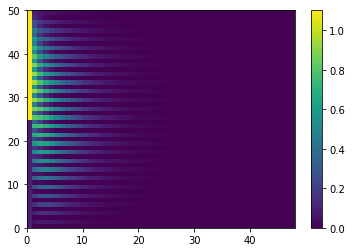

In [6]:
plt.pcolor(uu[:,::100])
plt.colorbar()


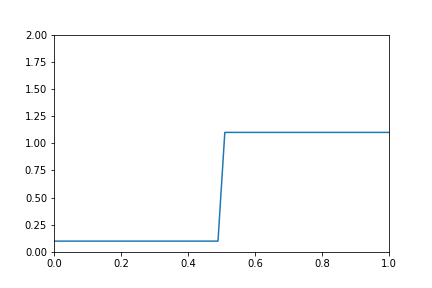
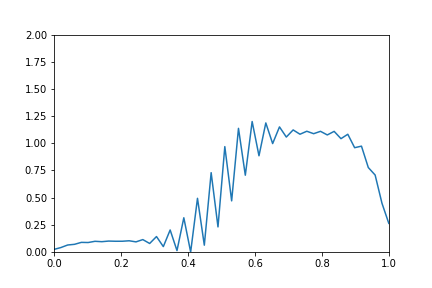
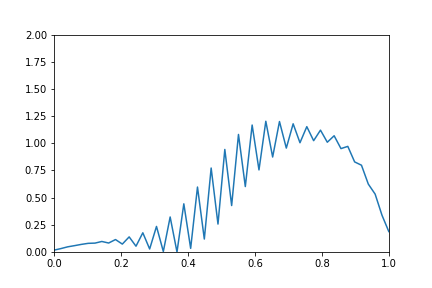
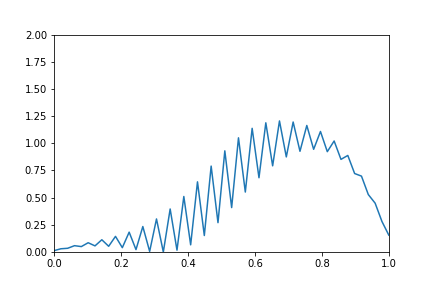
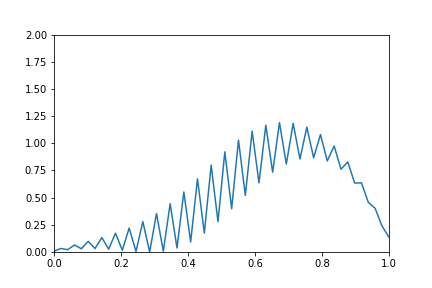
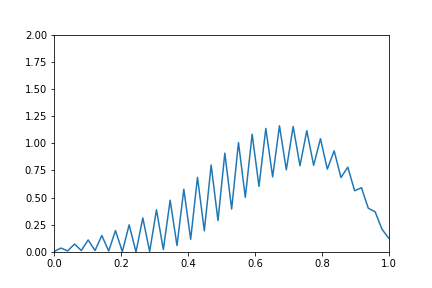
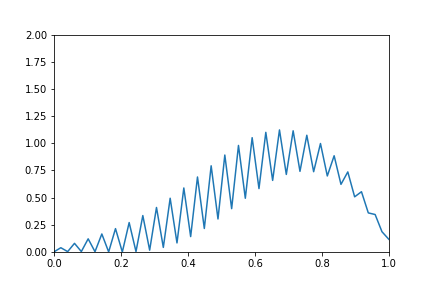
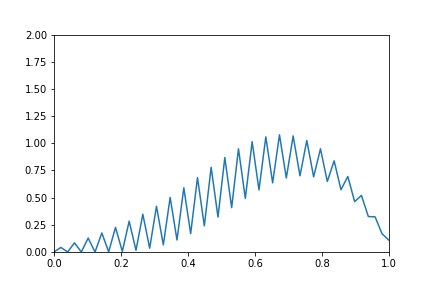
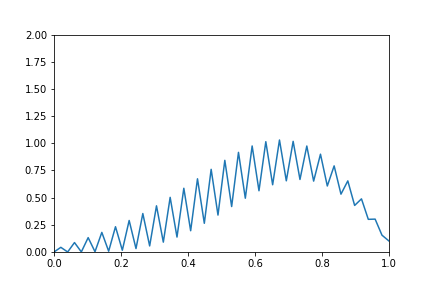
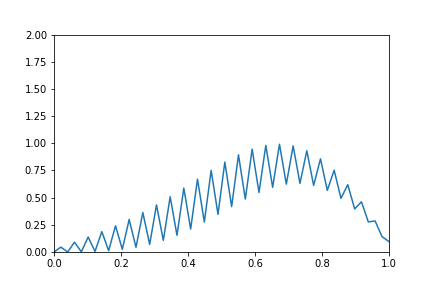
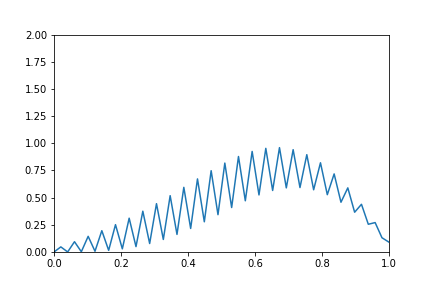
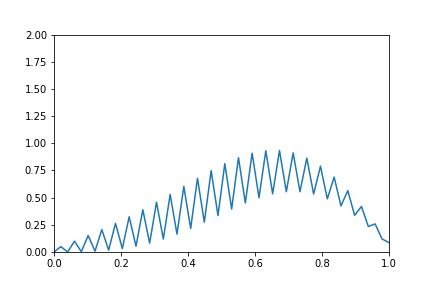
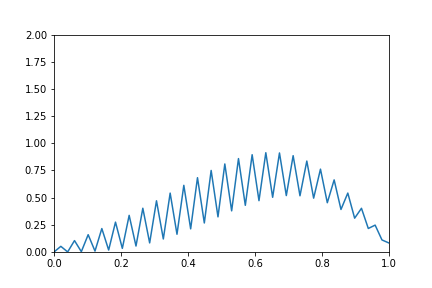
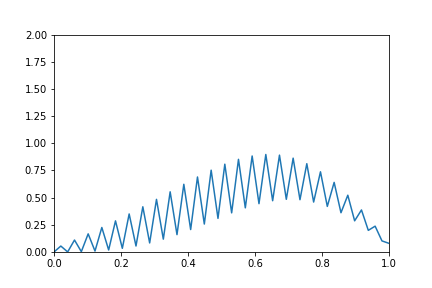
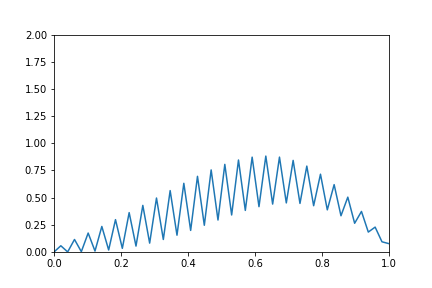
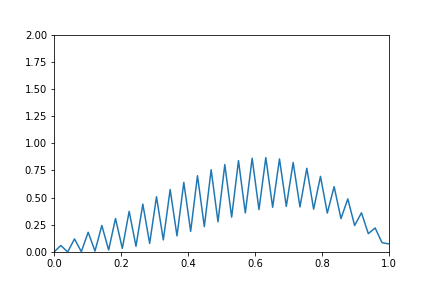
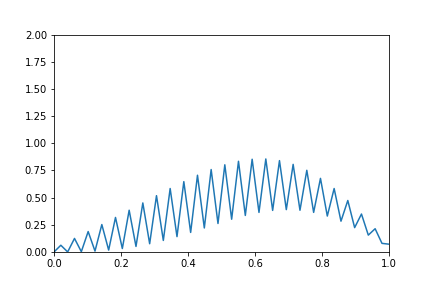
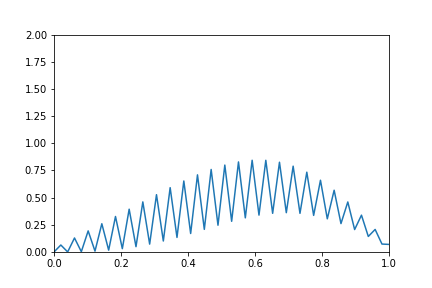
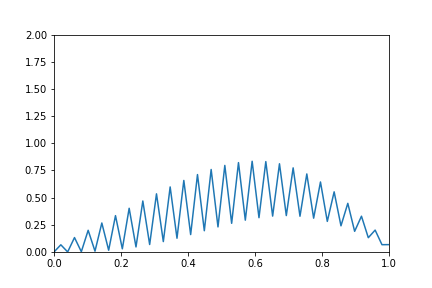
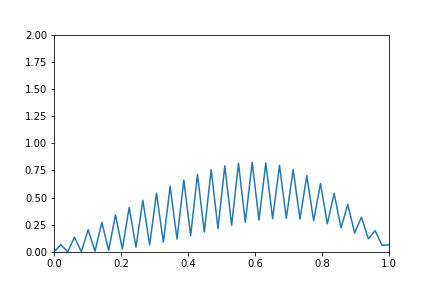
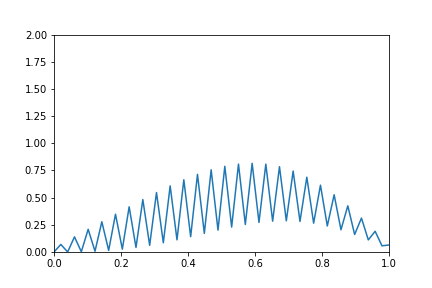
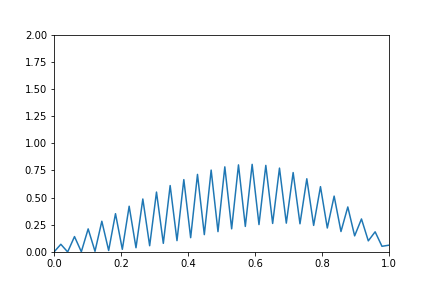
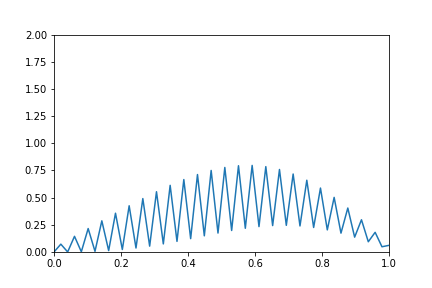
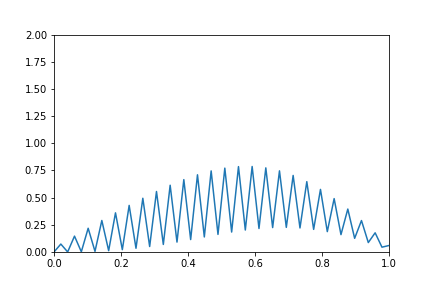
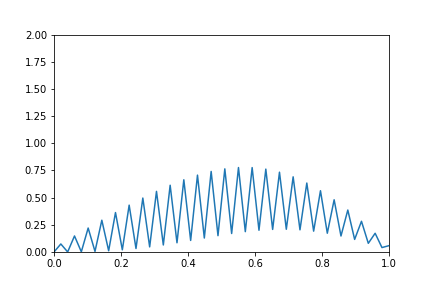
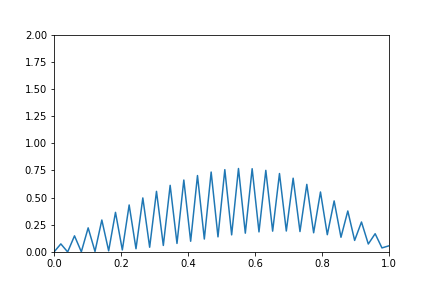
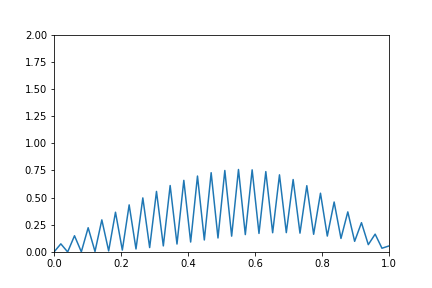
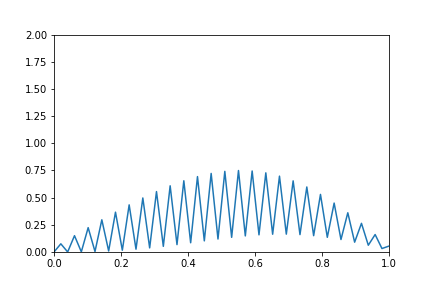
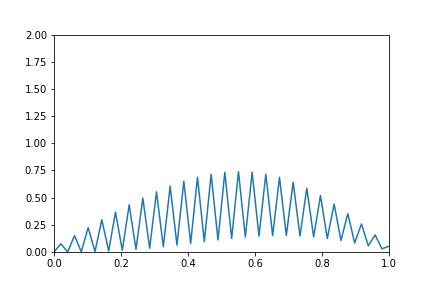
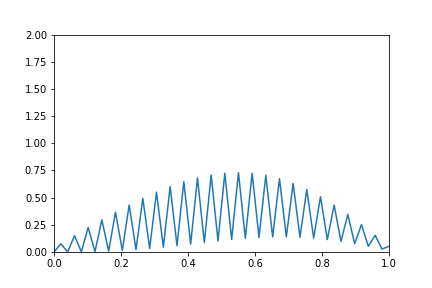
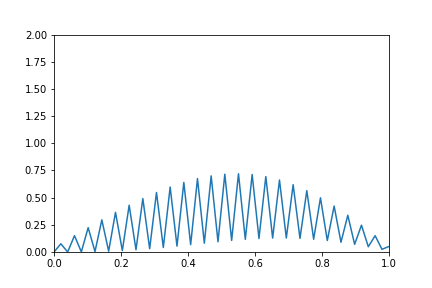
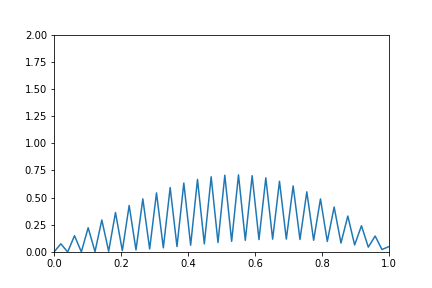
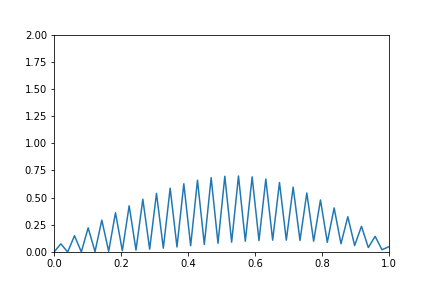
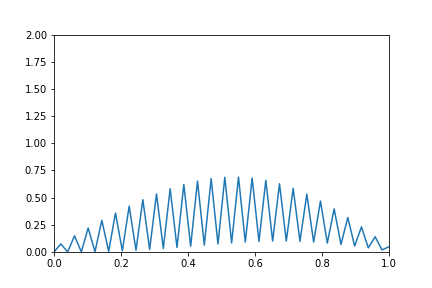
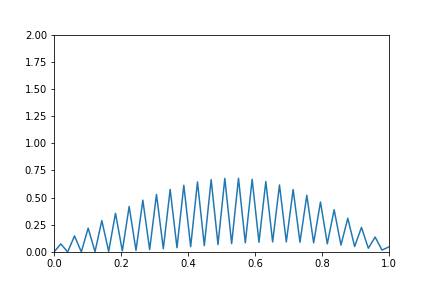
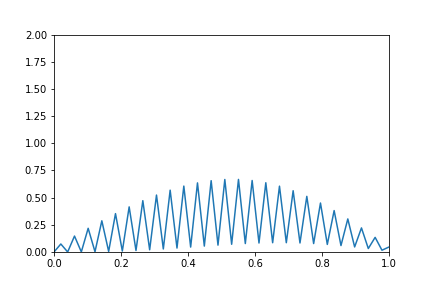
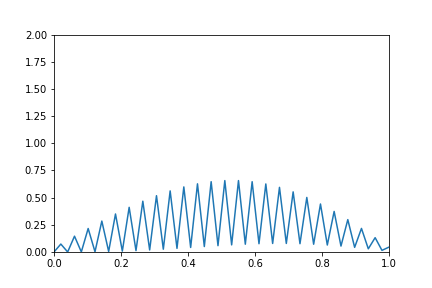
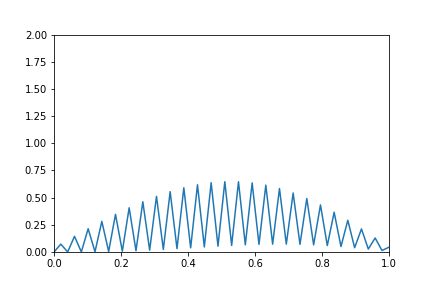
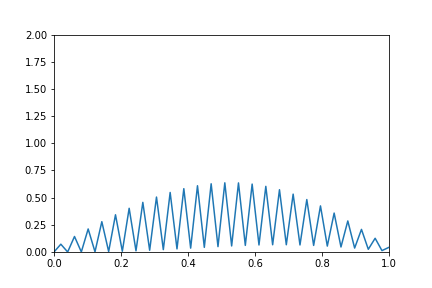
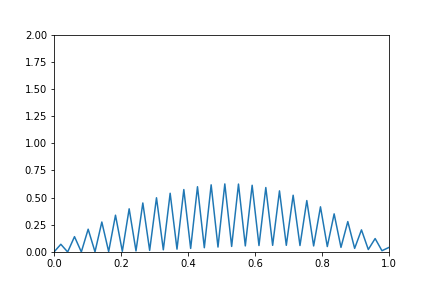
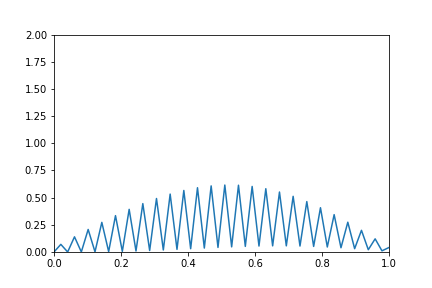
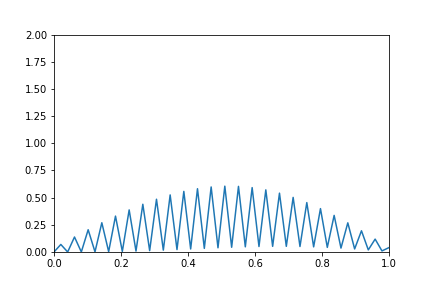
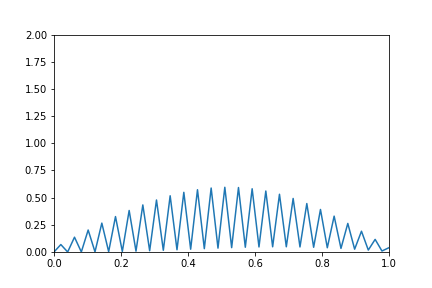
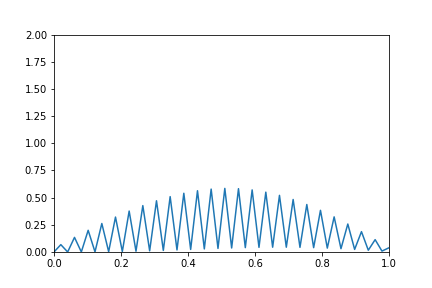
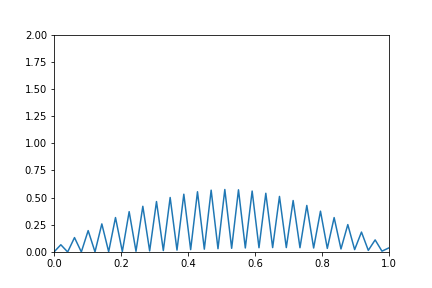
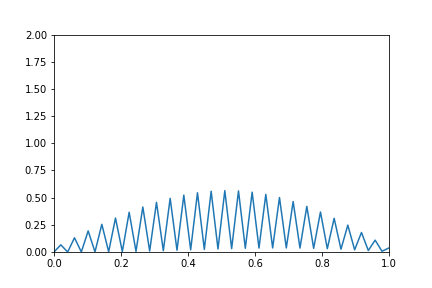
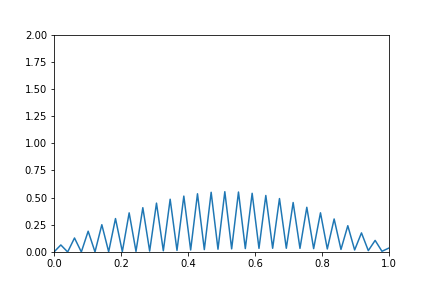
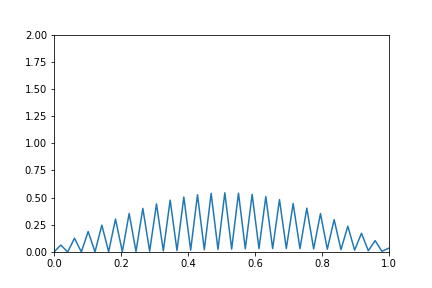
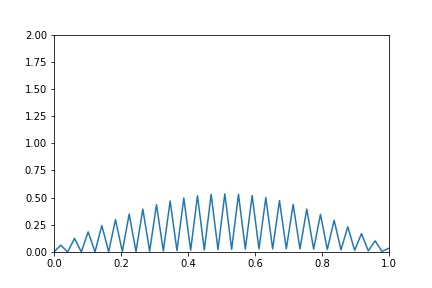
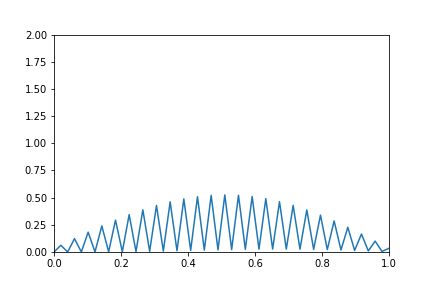
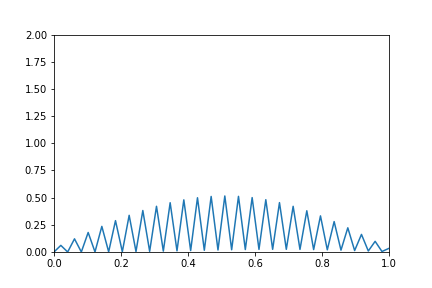
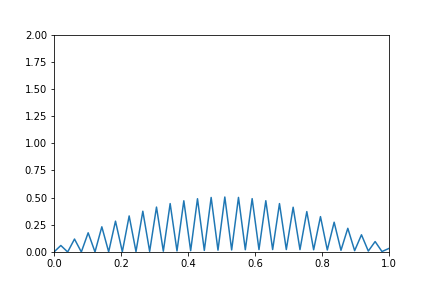
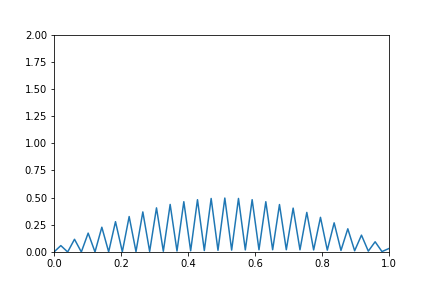
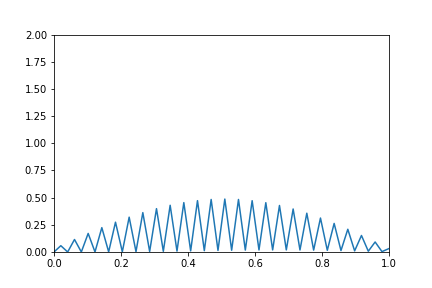
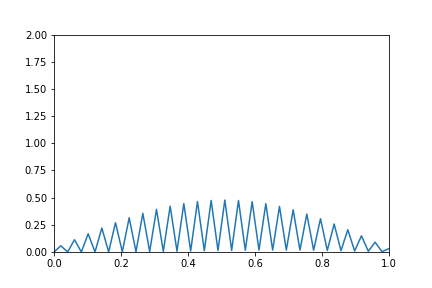
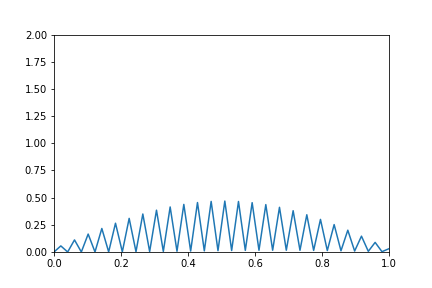
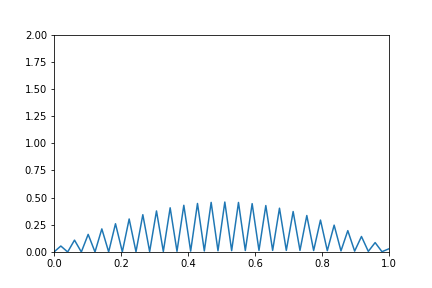
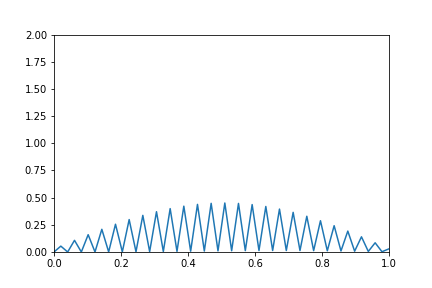
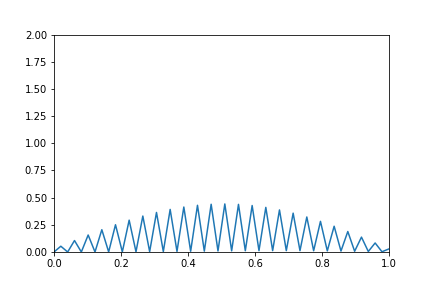
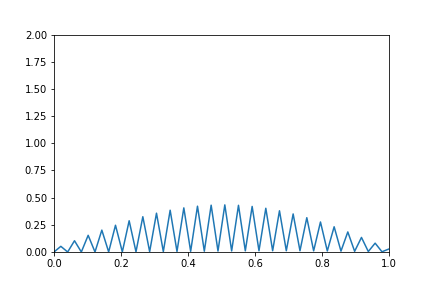
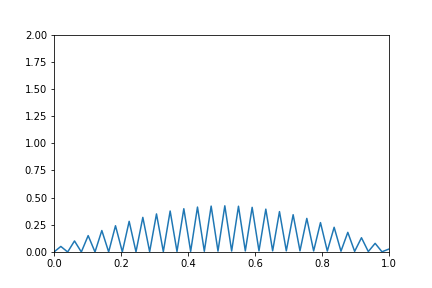
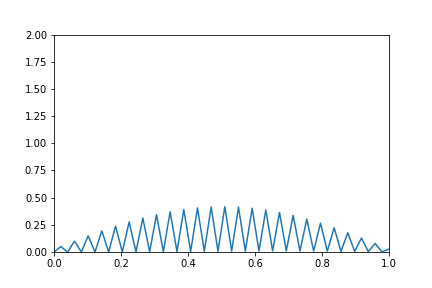
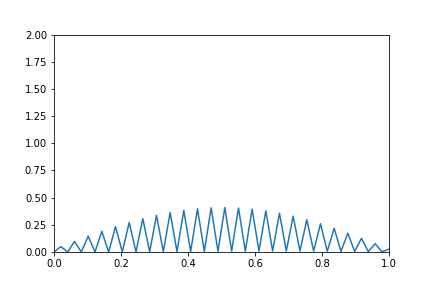
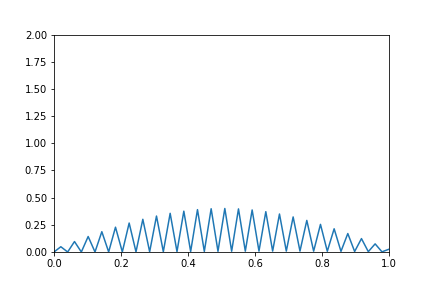
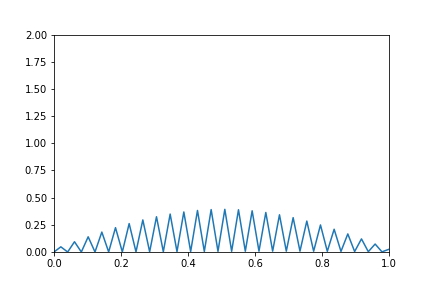
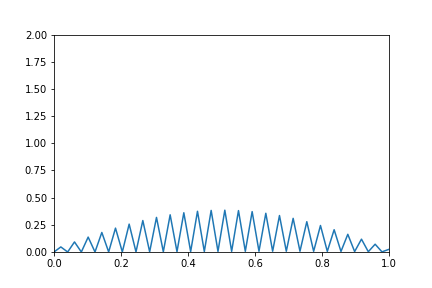
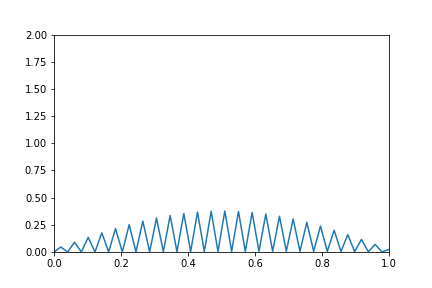
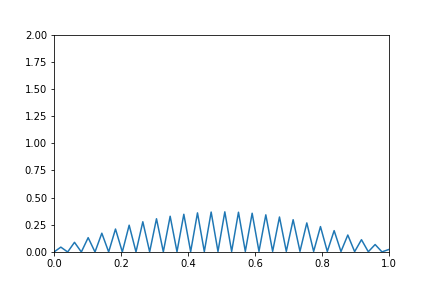
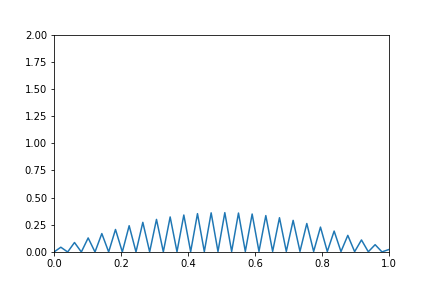
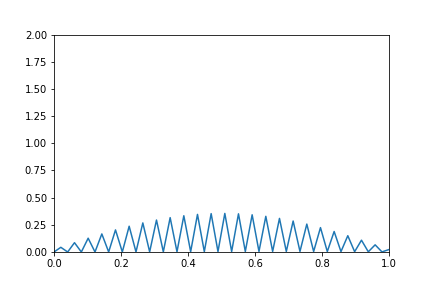
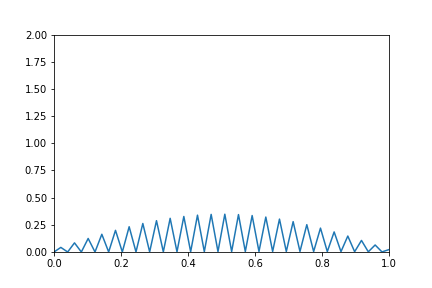
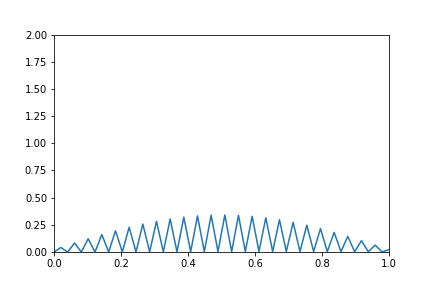
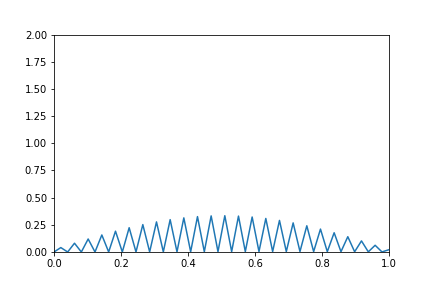
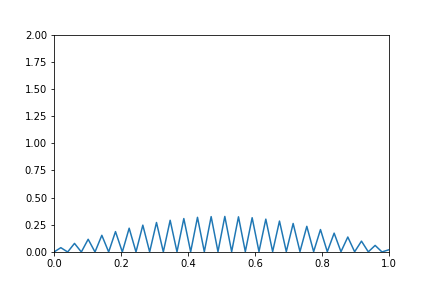
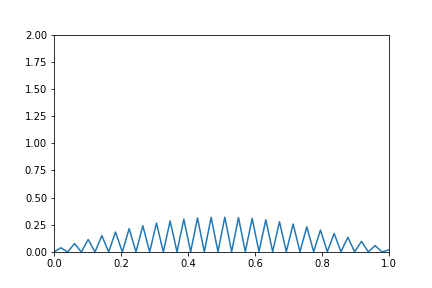
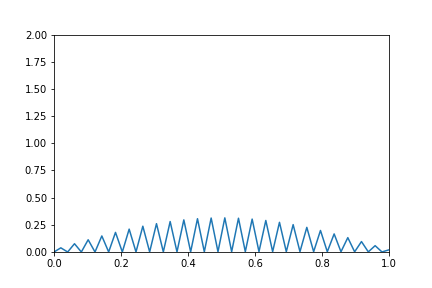
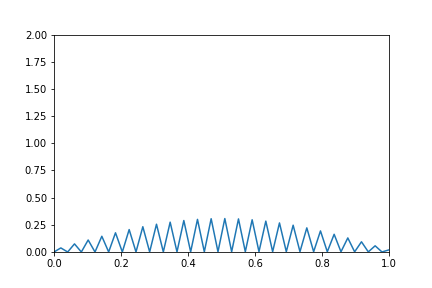
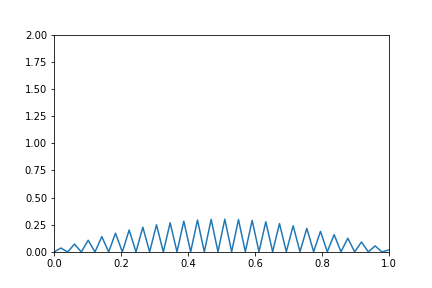
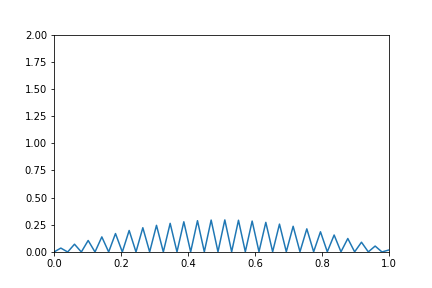
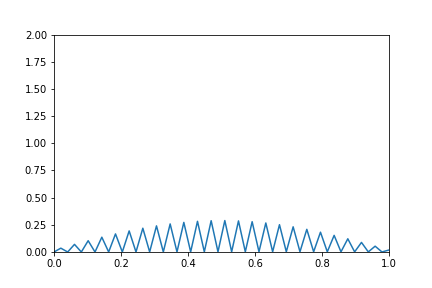
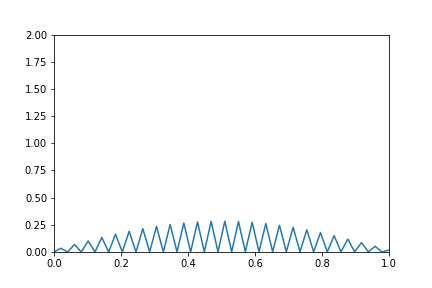
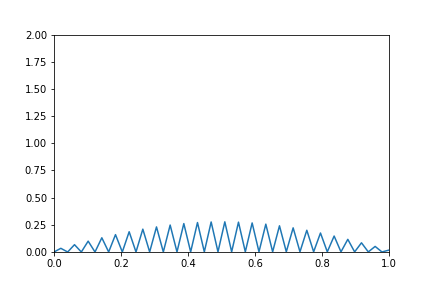
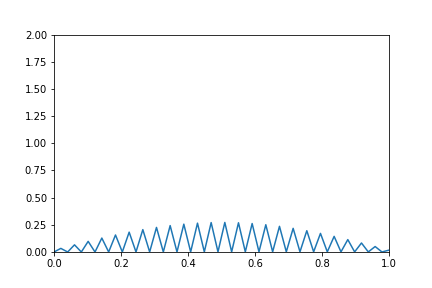
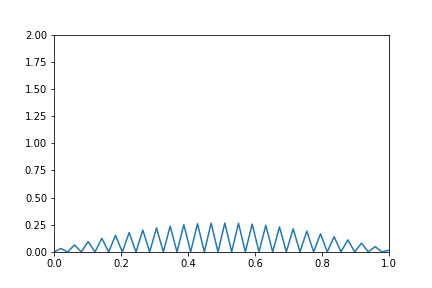
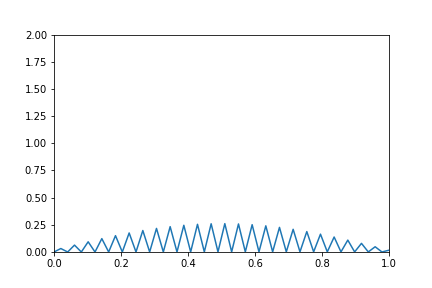
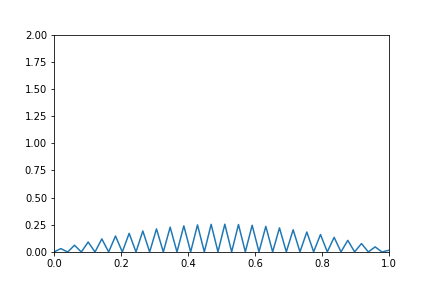
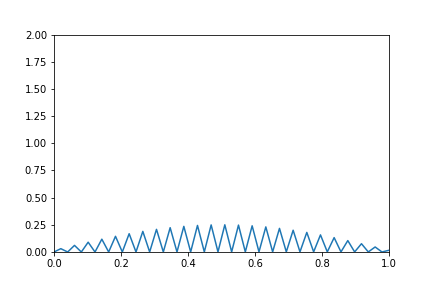
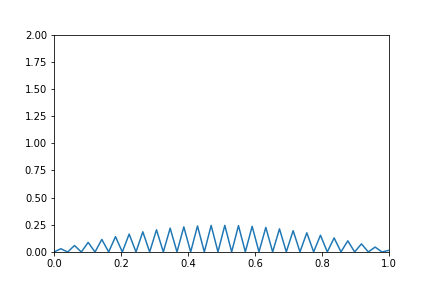
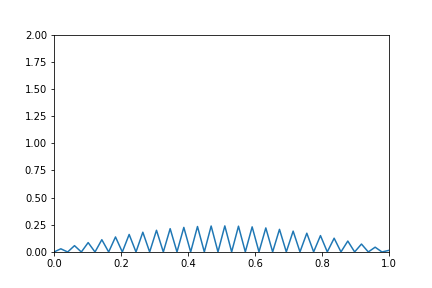
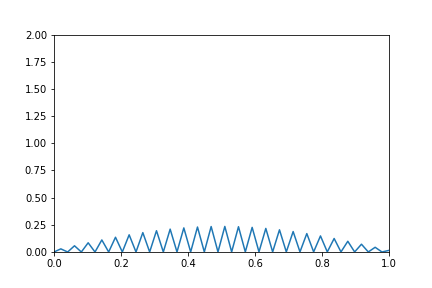
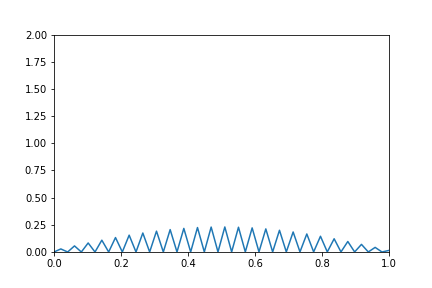
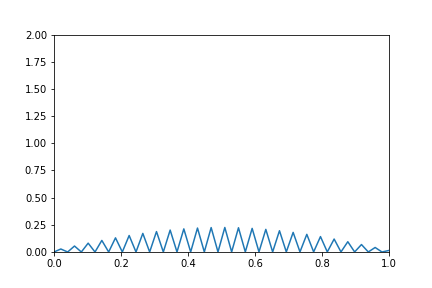
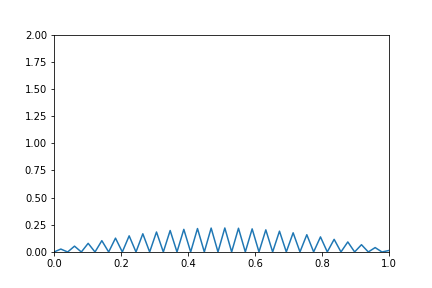
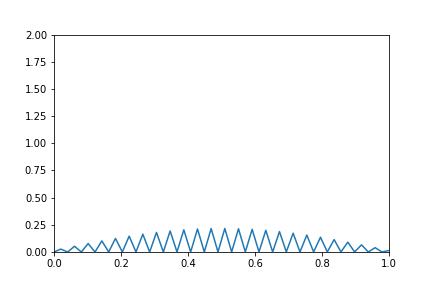
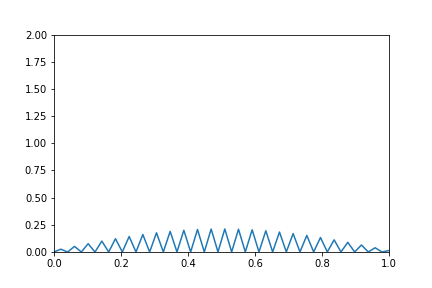
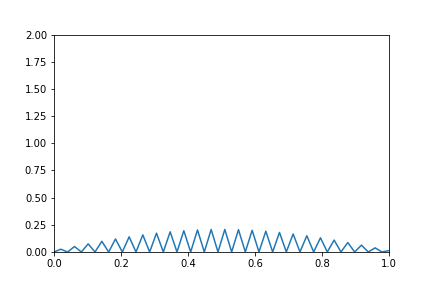
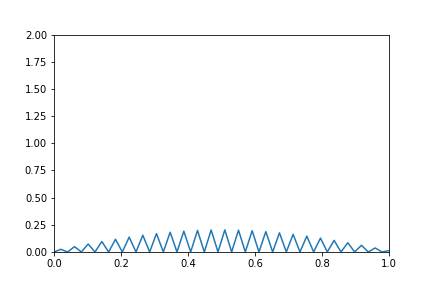
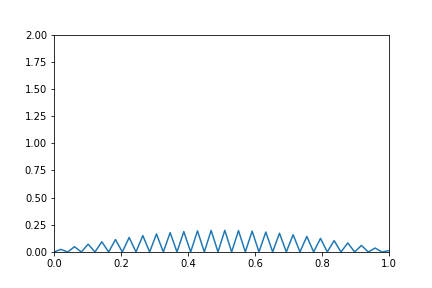
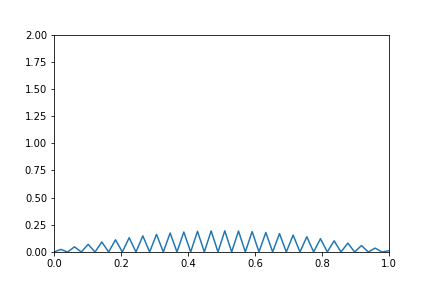
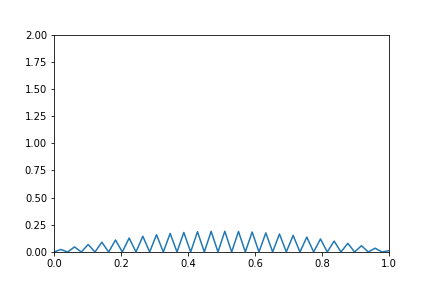

In [7]:
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display

fig = plt.figure()
line, = plt.plot([],[])
plt.ylim(0,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,10*j]);
    
animation.FuncAnimation(fig,plot_frame)

# Advection
## Centered difference

In [19]:
N=50
x = np.linspace(0,1,N)
dx = x[1]-x[0]

def f_centered_advection(u):
    du = np.zeros_like(u)
    du[1:-1] = (u[2:]-u[:-2])
    du[0] = u[1]-u[-1]
    du[-1] = u[0]-u[-2]
    return -du/(2*dx)

u0 = (x<0.5)+0.5
u0 = np.sin(2*np.pi*x)+1.

dt = 2.5*dx

tt, uu = RRK_pos_DIRK(trbdf,dt=dt,f=f_centered_advection,w0=u0,t_final=10.,relaxation=True)
print(np.min(uu))

gam:  0.9727177443157452
gam:  0.676883556920781
gam:  0.9972979203811128
gam:  0.9237674928685222
gam:  0.8962817055456118
gam:  0.9391619874943833
0.0


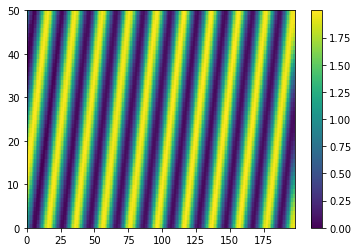

In [20]:
plt.pcolor(uu[:,::1])
plt.colorbar()


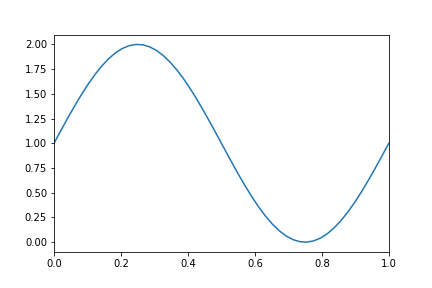
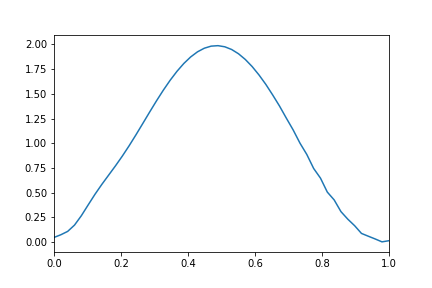
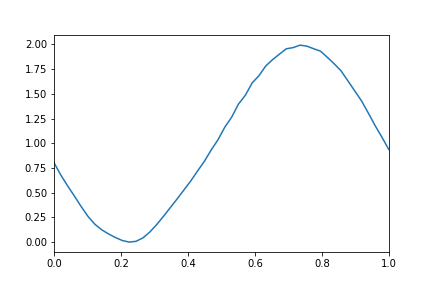
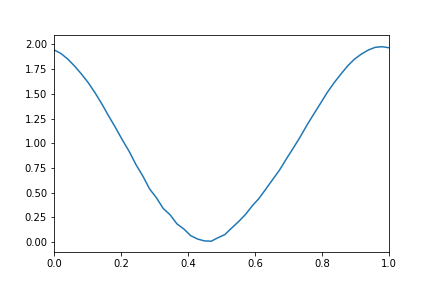
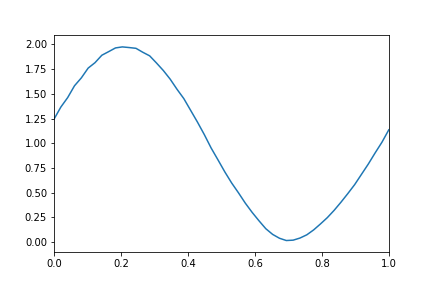
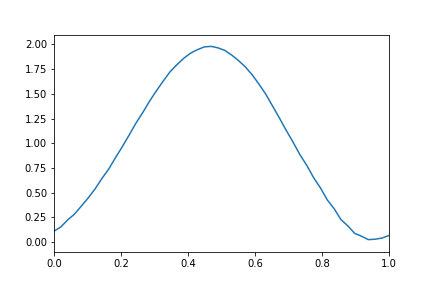
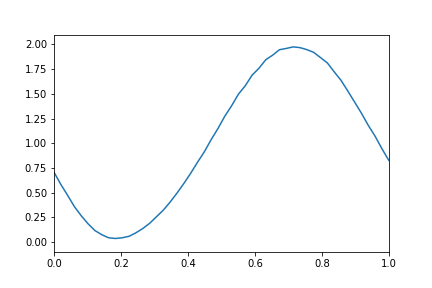
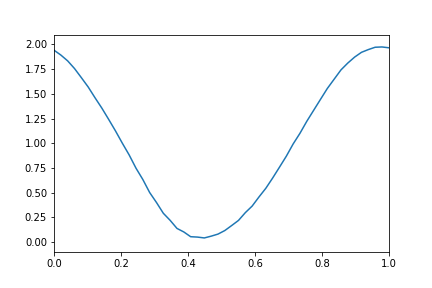
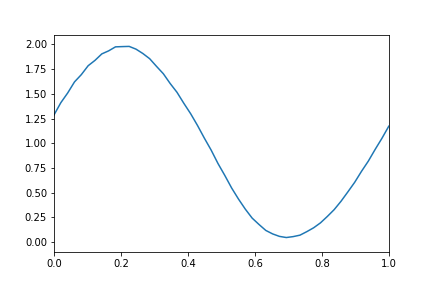
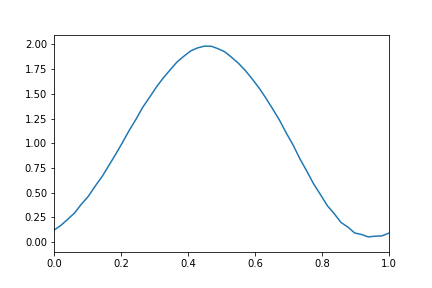
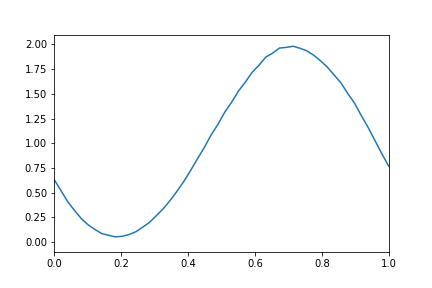
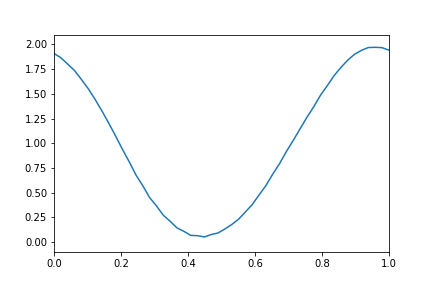
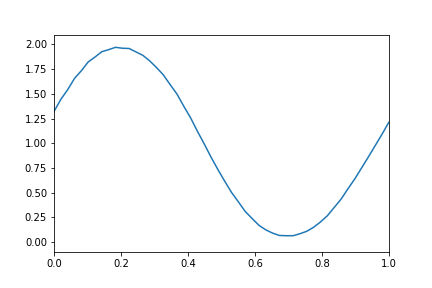
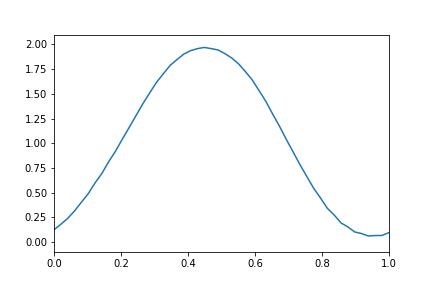
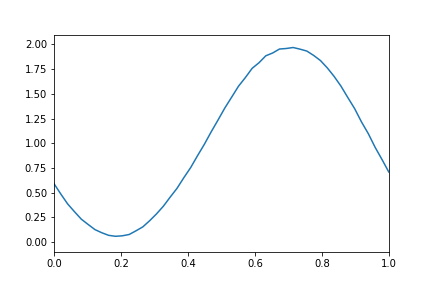
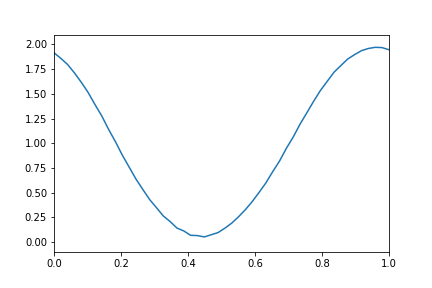
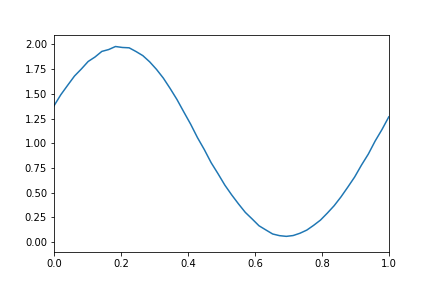
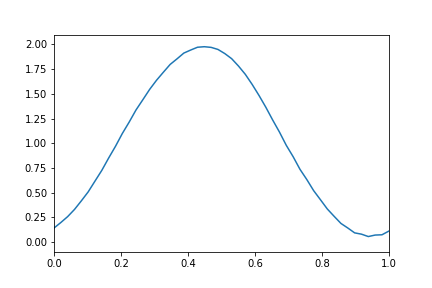
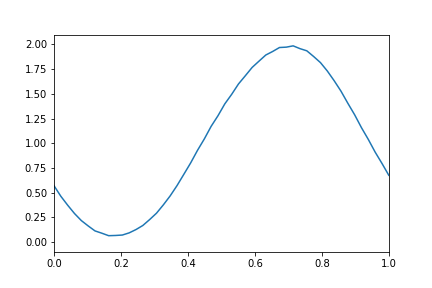
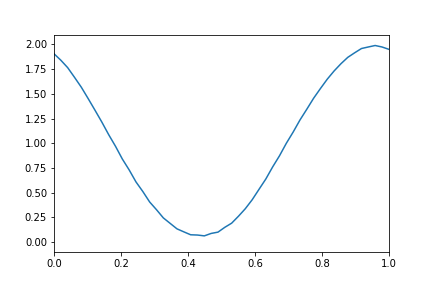
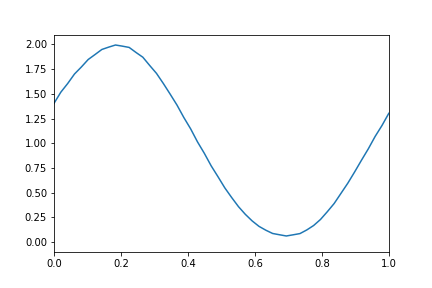
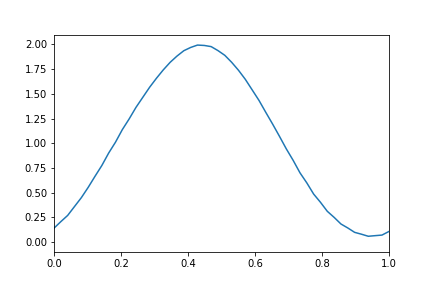
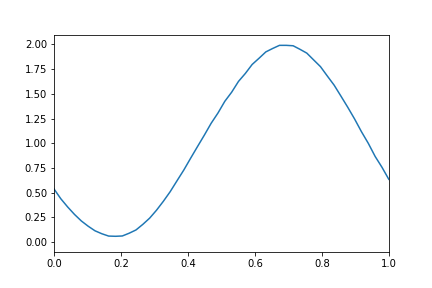
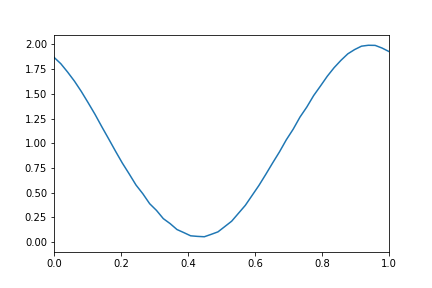
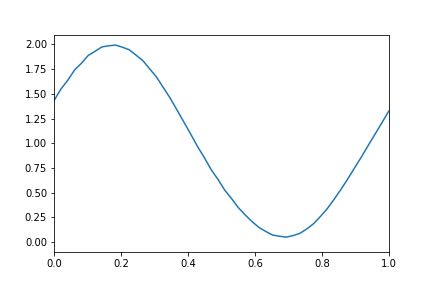
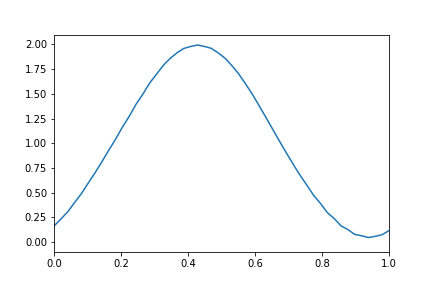
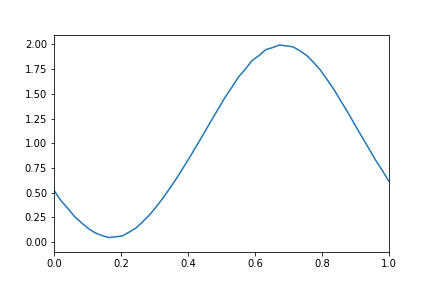
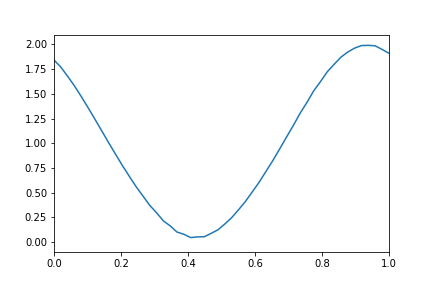
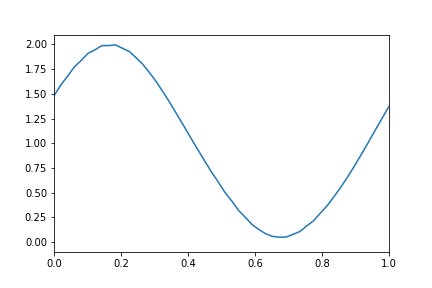
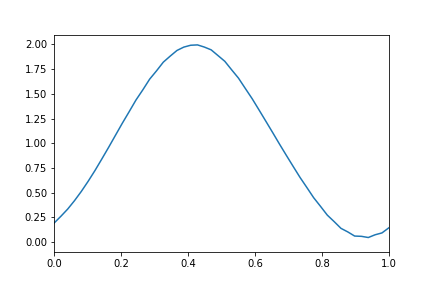
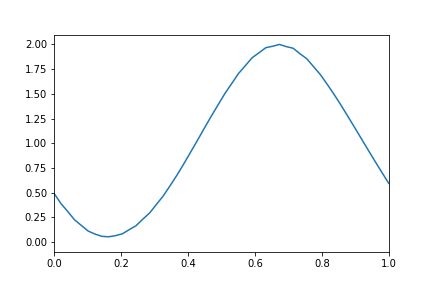
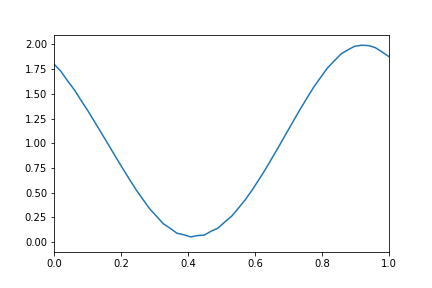
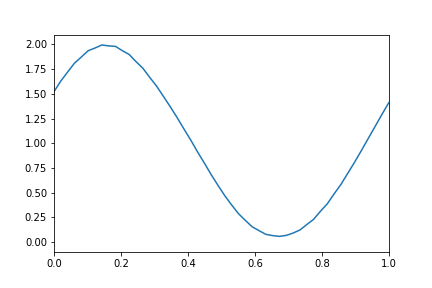
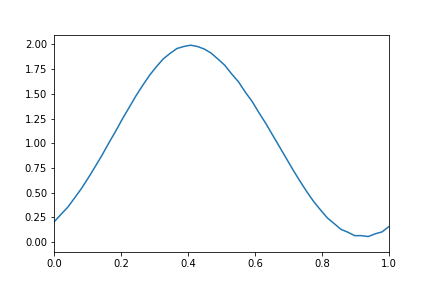
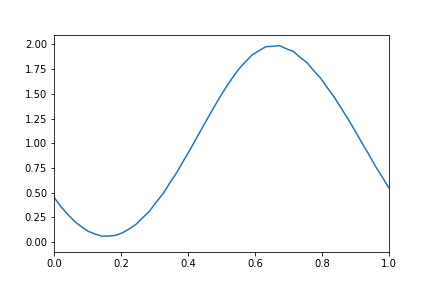
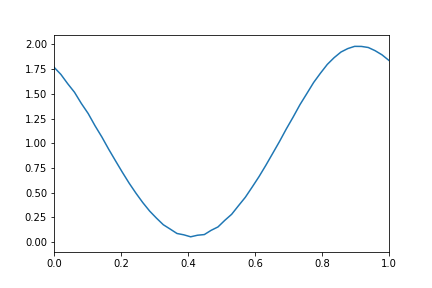
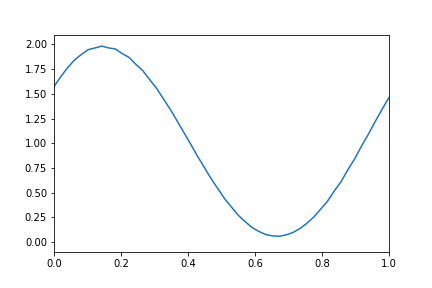
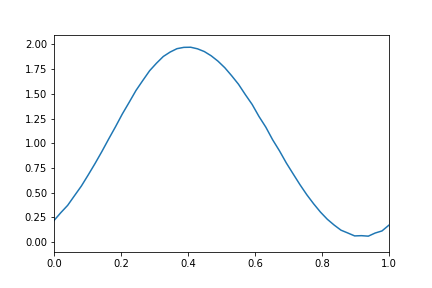
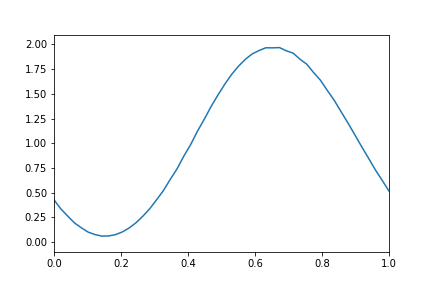

In [21]:
fig = plt.figure()
line, = plt.plot(x,uu[:,0])
plt.xlim(0,1)
skip = 5
def plot_frame(j):
    line.set_data(x,uu[:,skip*j]);
    
animation.FuncAnimation(fig,plot_frame,frames=int(uu.shape[1]/skip))

In [22]:
def f_upwind_advection(u):
    du = np.zeros_like(u)
    du[1:] = u[1:]-u[:-1]
    du[0] = u[0]-u[-1]
    return -du/dx

u0 = (x<0.5)+0.1
#u0 = np.sin(2*np.pi*x)+1.
dt = 20.*dx

tt, uu = RRK_pos_DIRK(trbdf,dt=dt,f=f_centered_advection,w0=u0,t_final=10.,relaxation=True)
print(np.min(uu))

gam:  0.860868767004875
0.0


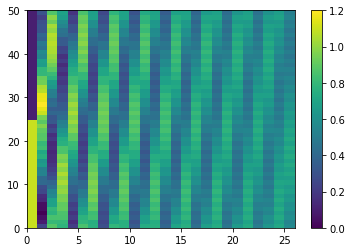

In [23]:
plt.pcolor(uu[:,::1])
plt.colorbar()


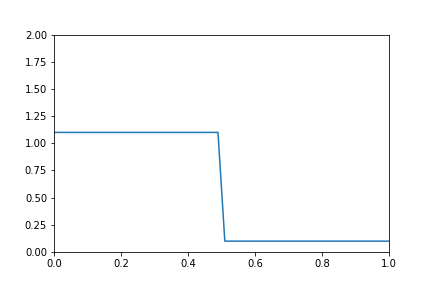
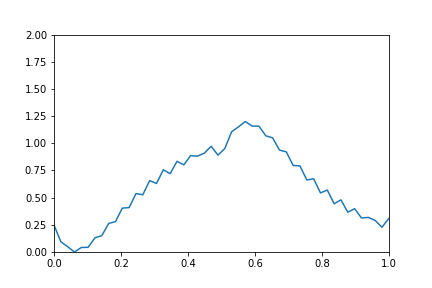
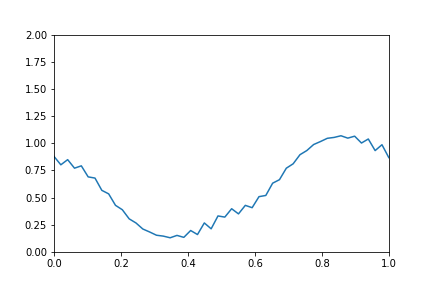
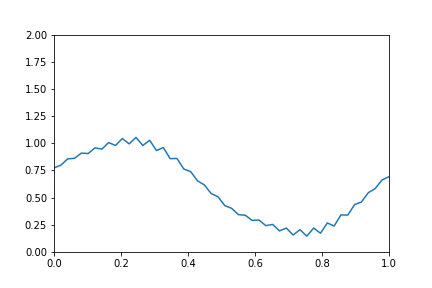
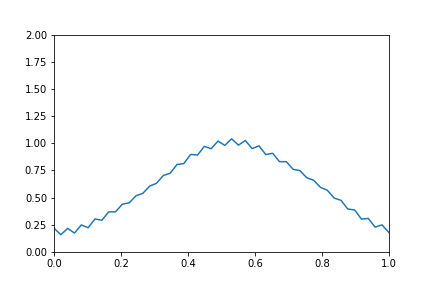
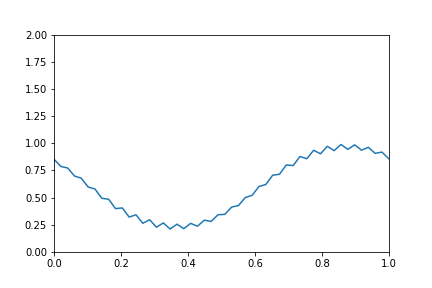
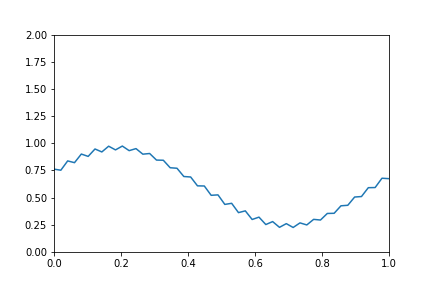
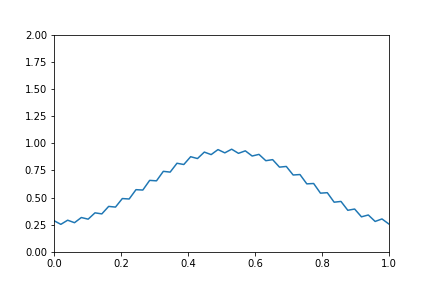
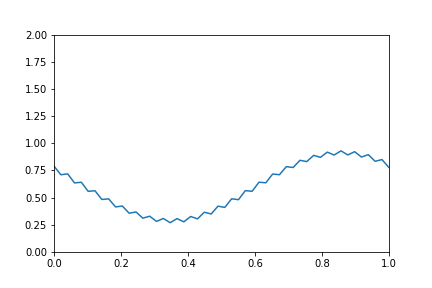
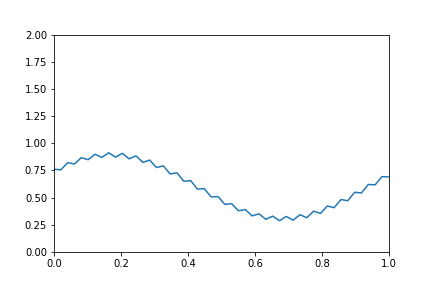
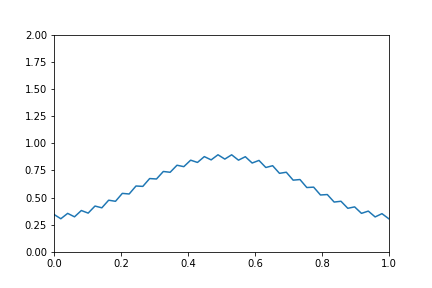
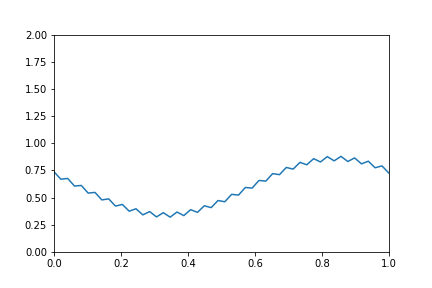
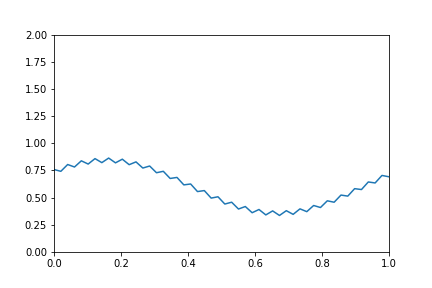
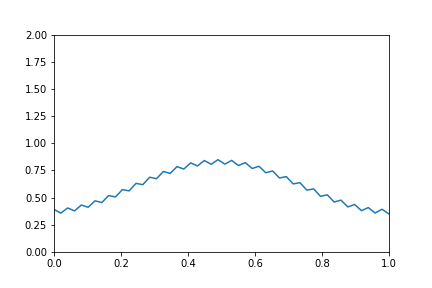
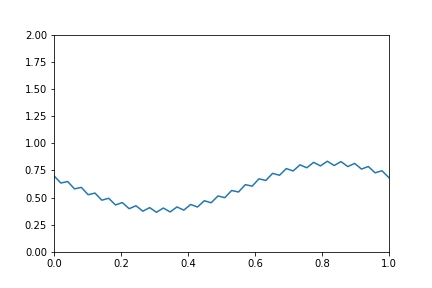
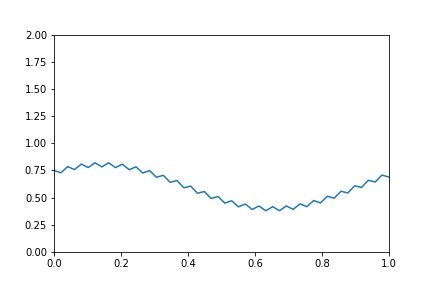
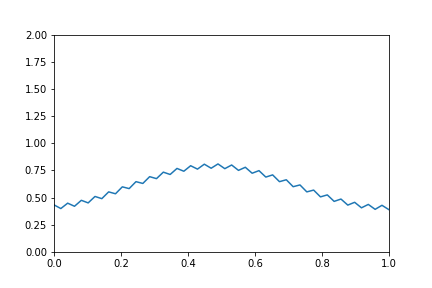
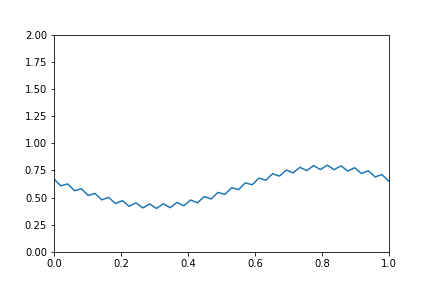
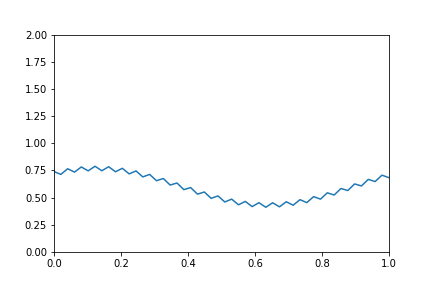
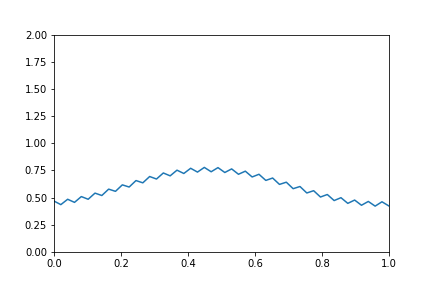
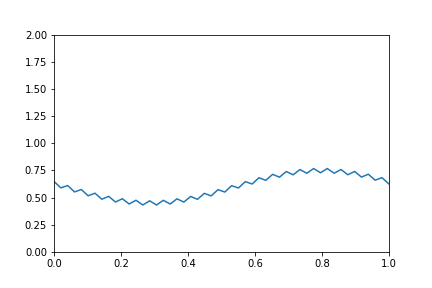
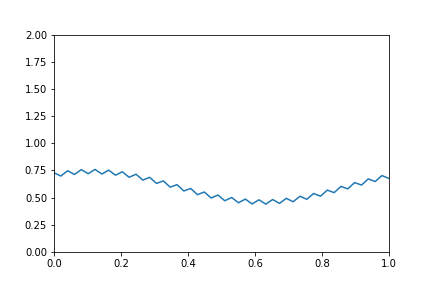
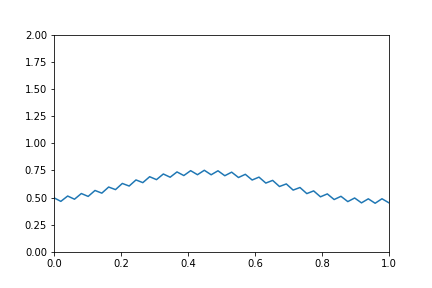
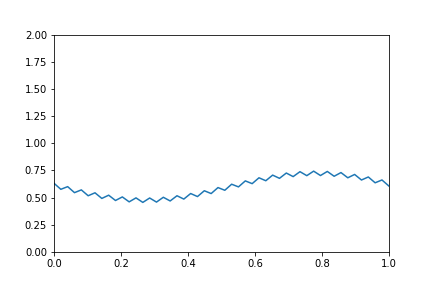
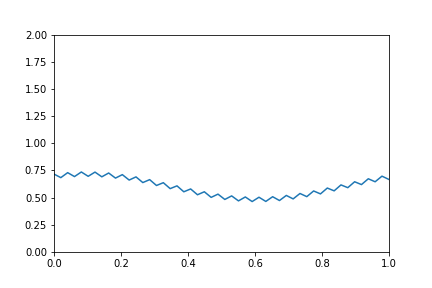
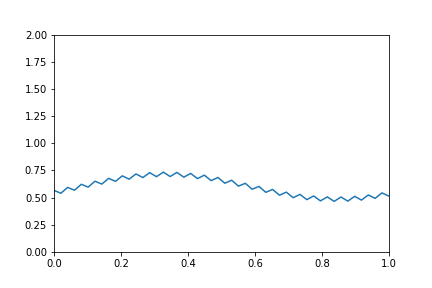

In [24]:
fig = plt.figure()
line, = plt.plot(x,uu[:,0])
plt.xlim(0,1)
plt.ylim(0,2)
skip = 1
def plot_frame(j):
    line.set_data(x,uu[:,skip*j]);
    
animation.FuncAnimation(fig,plot_frame,frames=int(uu.shape[1]/skip))

In [51]:
RK4 = rk.loadRKM('RK44').__num__()

u0 = (x<0.5)+0.5
#u0 = np.sin(2*np.pi*x)+1.
dt = 0.5*dx

tt, uu = RRK_pos_DIRK(RK4,dt=dt,f=f_centered_advection,w0=u0,t_final=1.,relaxation=True,print_gamma=1)
print(np.min(uu))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.02919740623137111



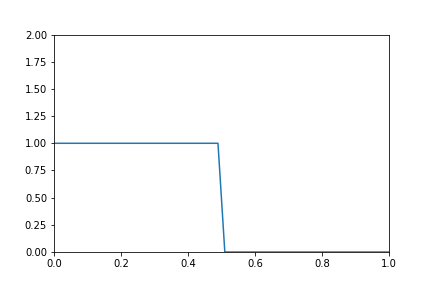
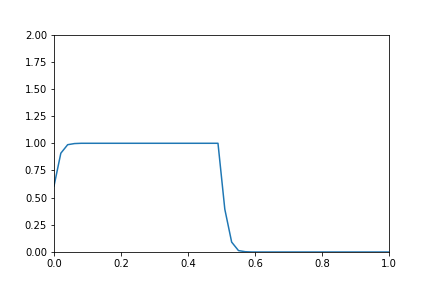
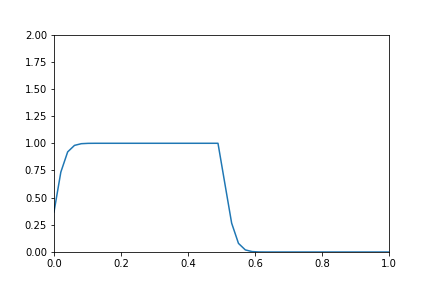
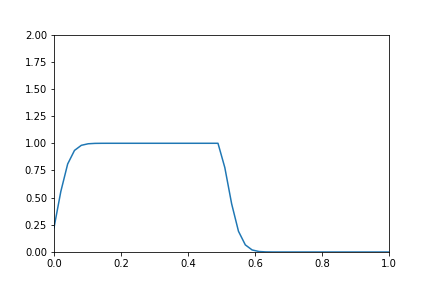
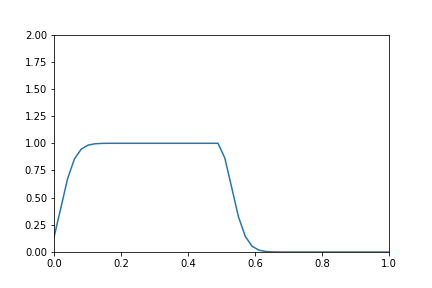
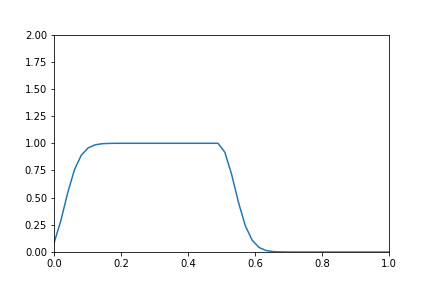
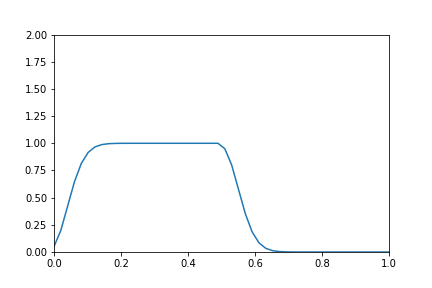
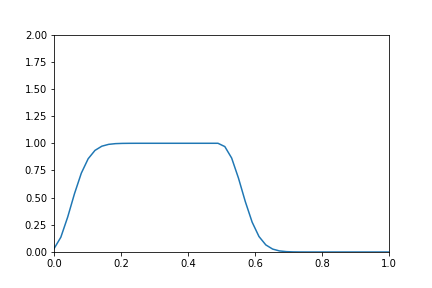
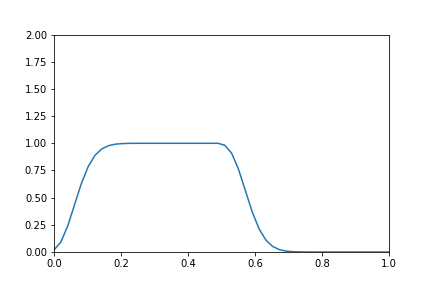
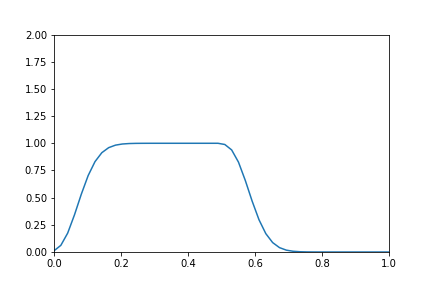
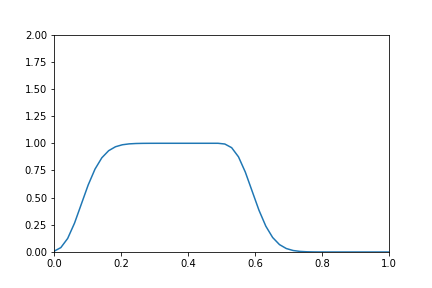
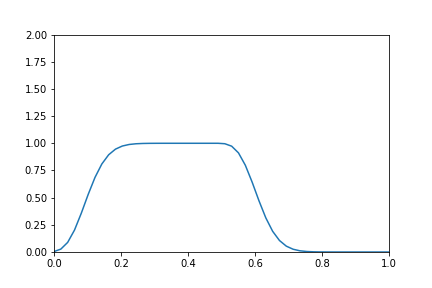
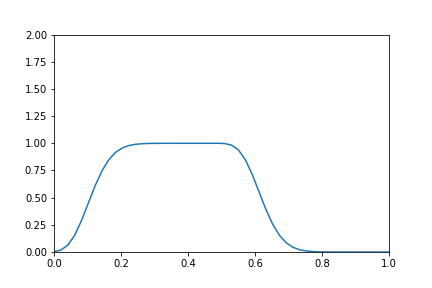
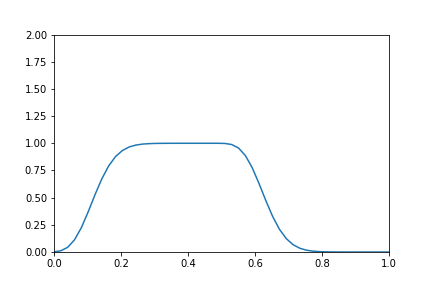
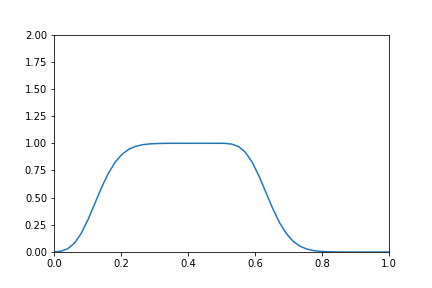
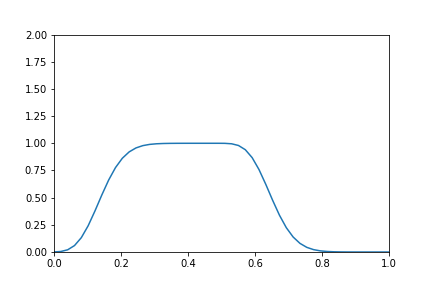
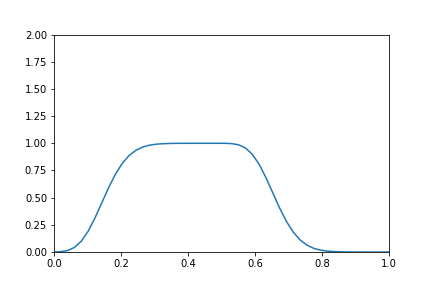
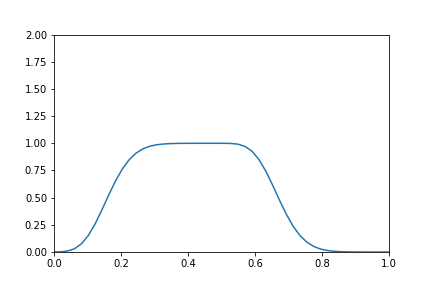
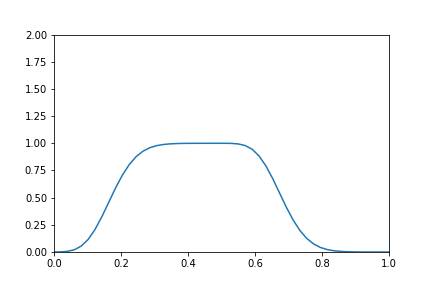
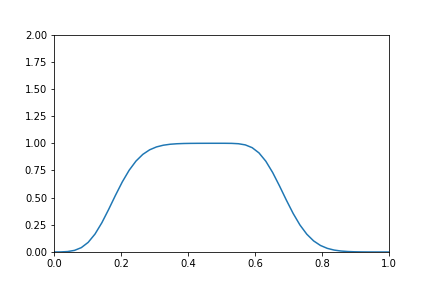
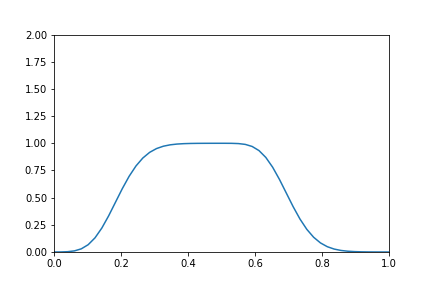
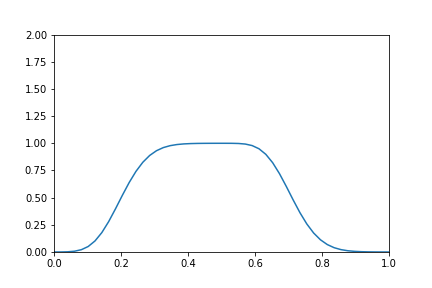
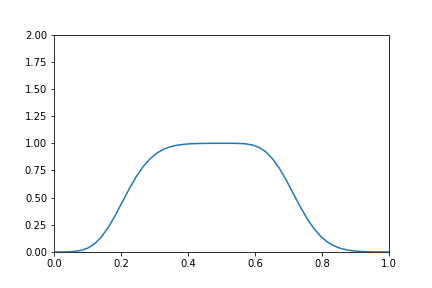
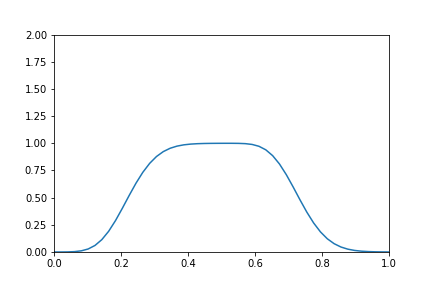
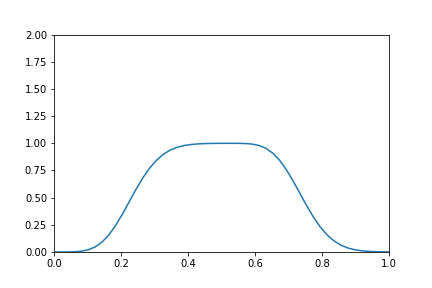
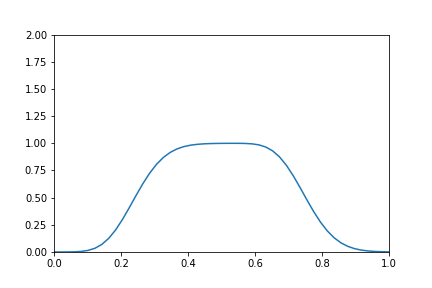
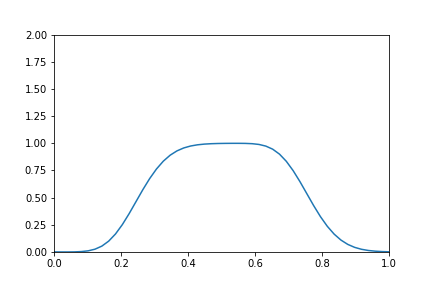
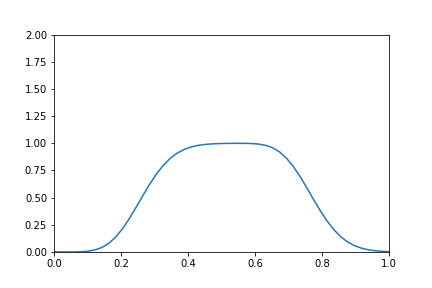
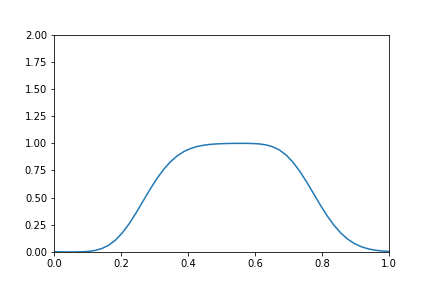
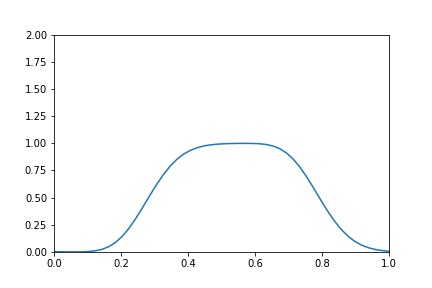
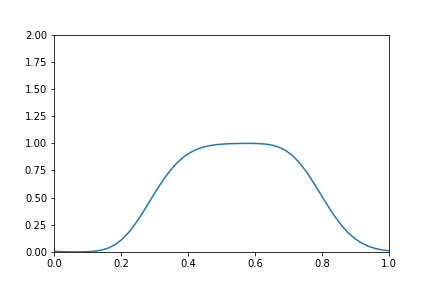
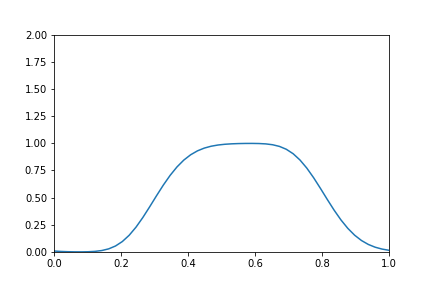
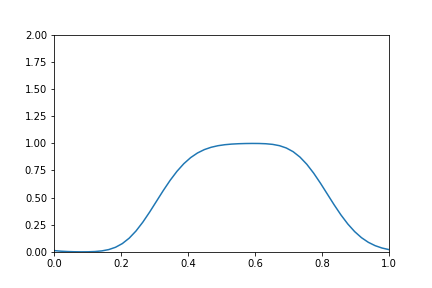
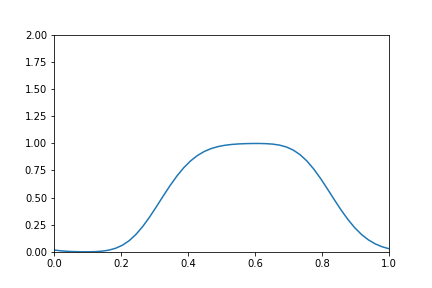
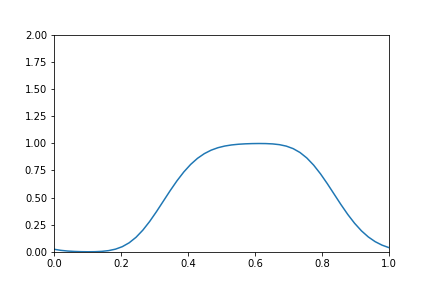
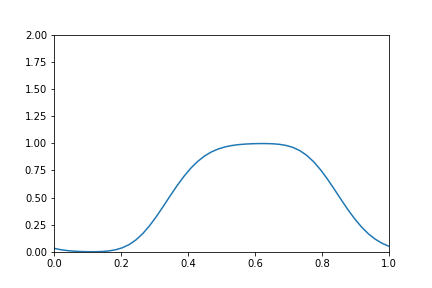
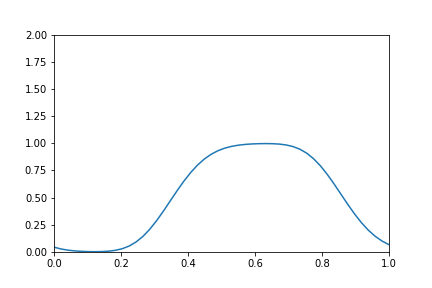
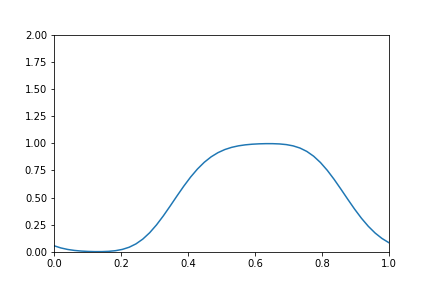
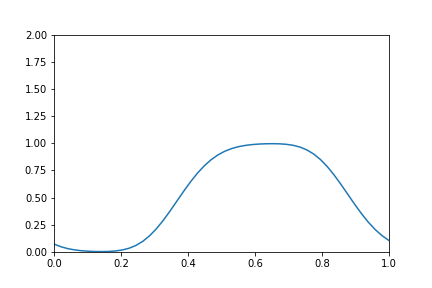
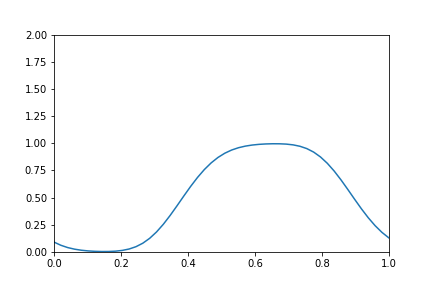
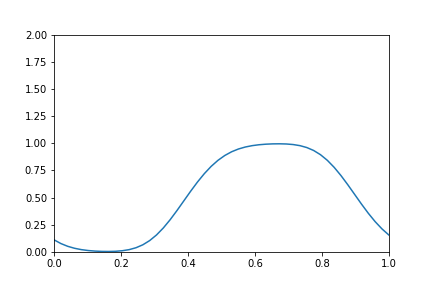
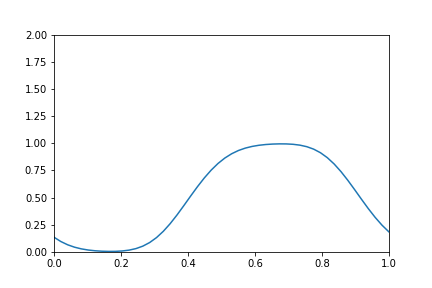
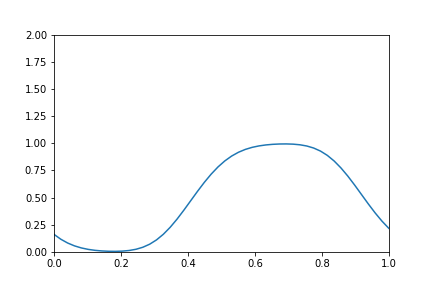
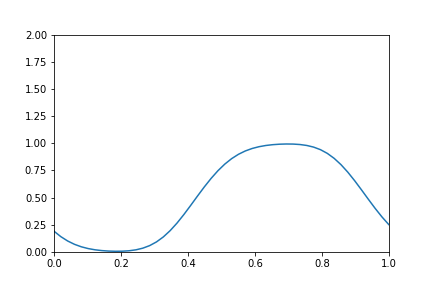
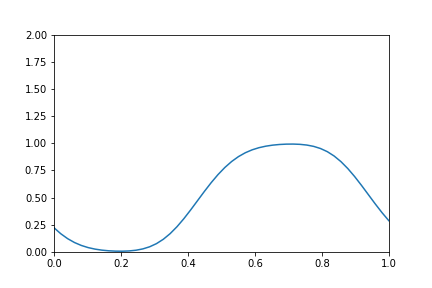
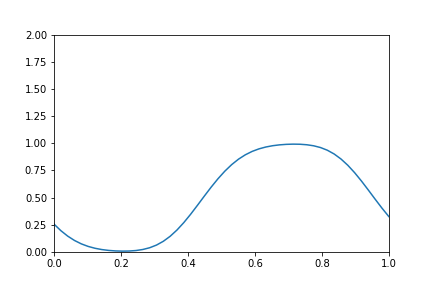
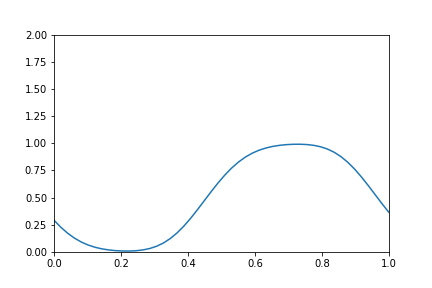
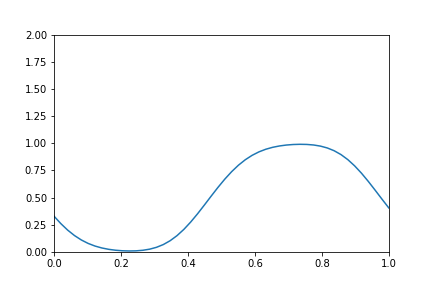
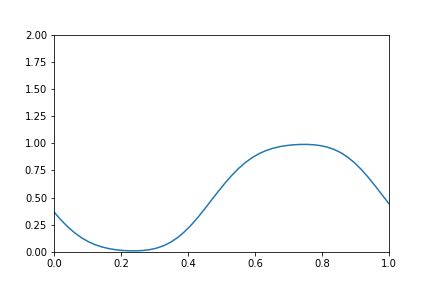
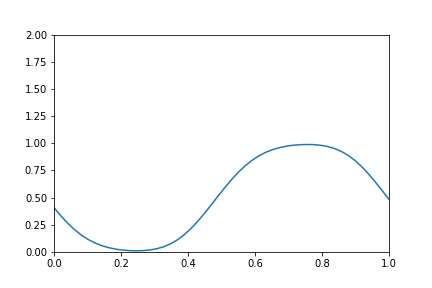
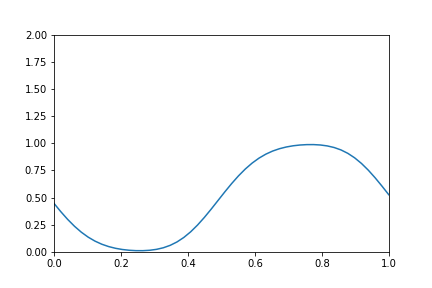
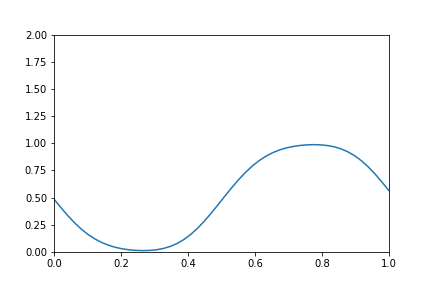
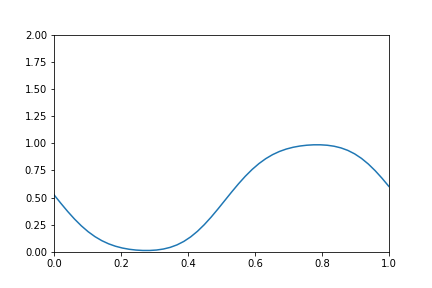
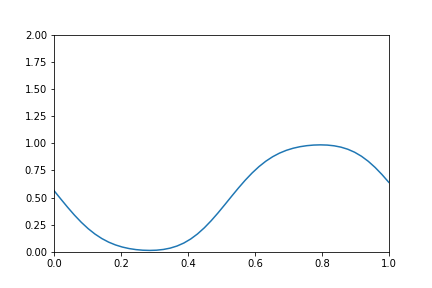
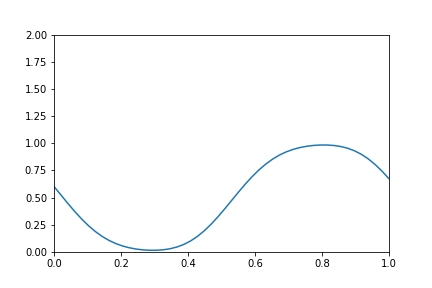
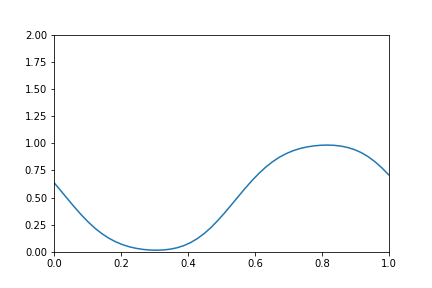
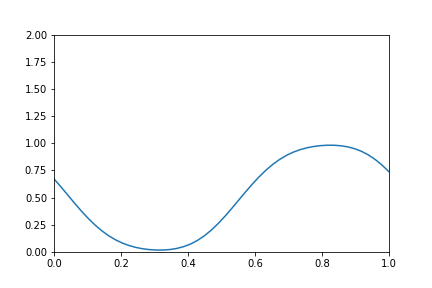
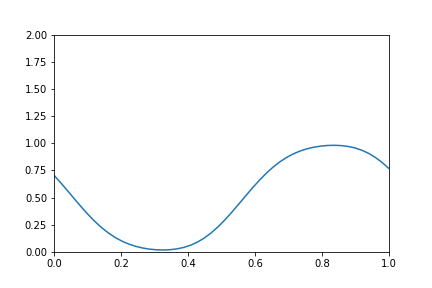
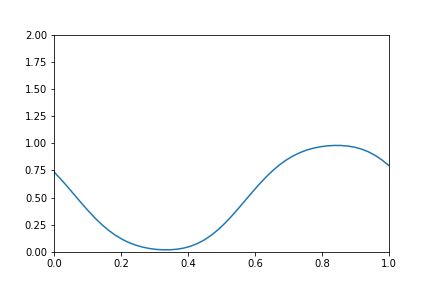
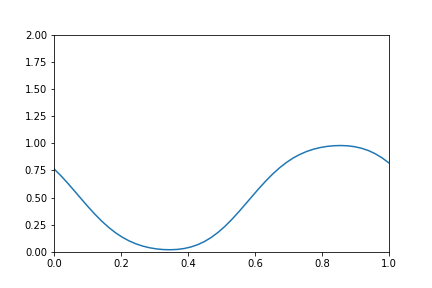
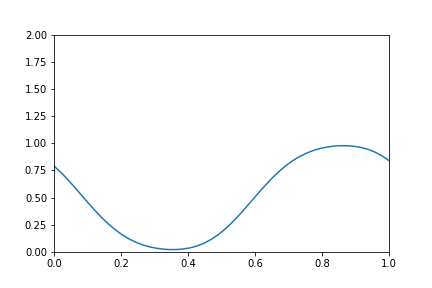
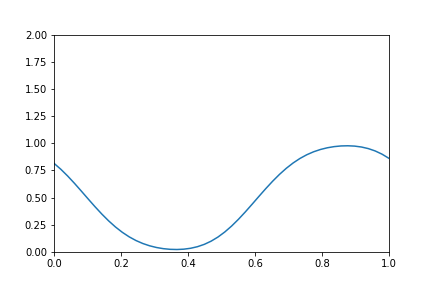
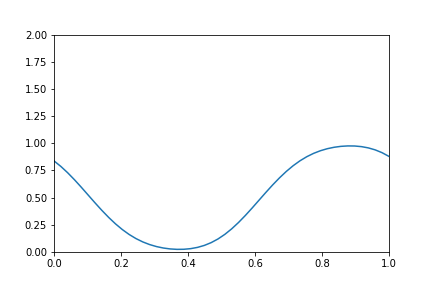
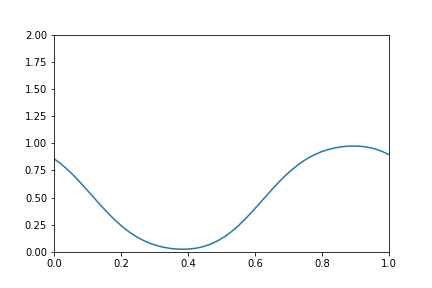
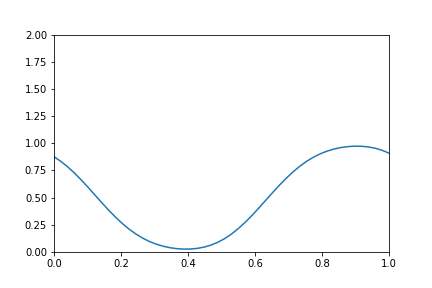
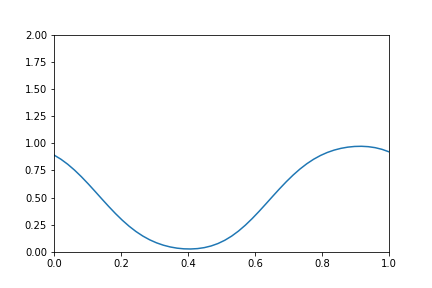
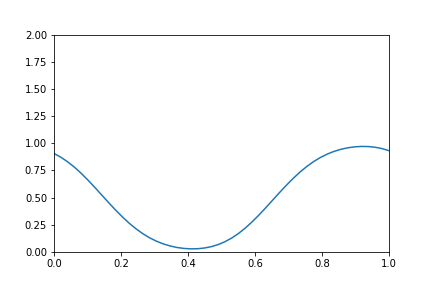
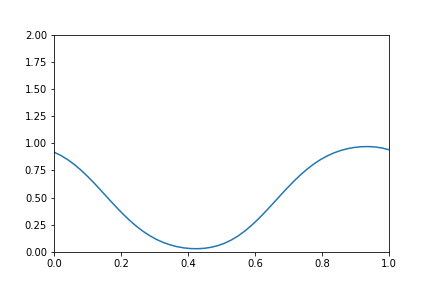
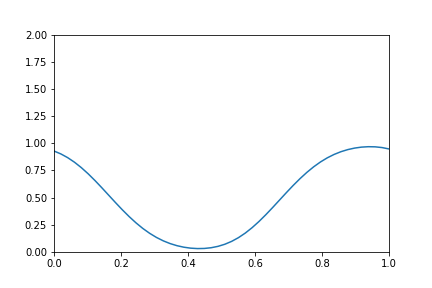
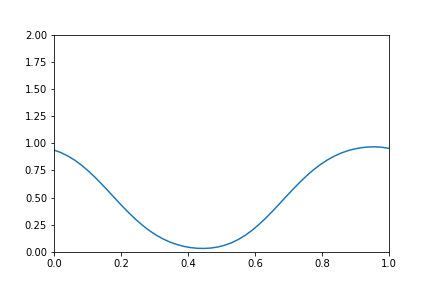
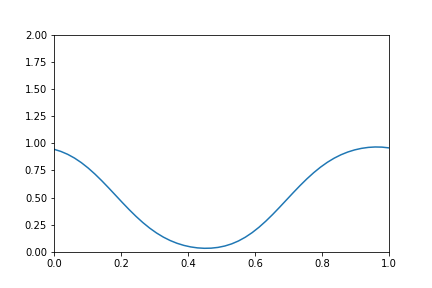
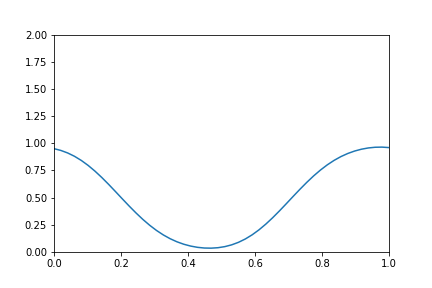
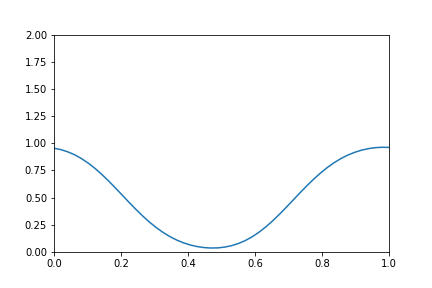
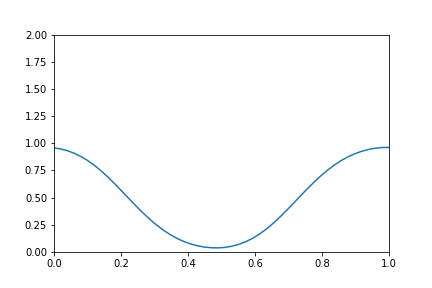
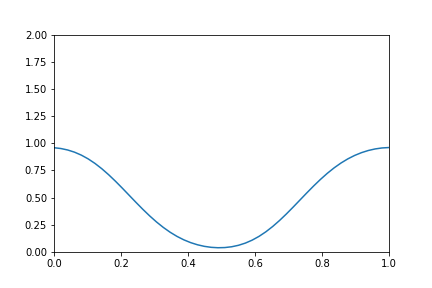
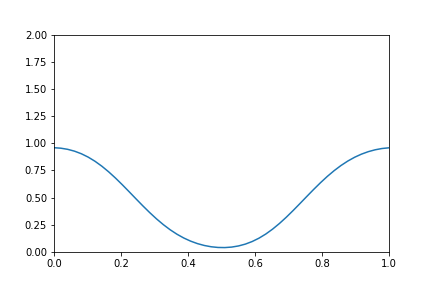
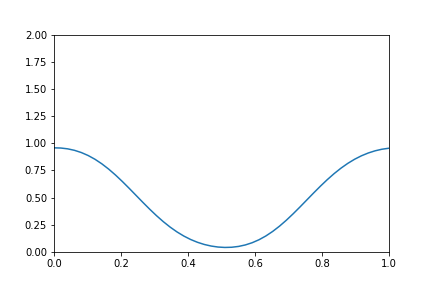
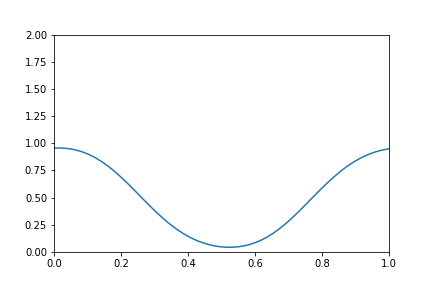
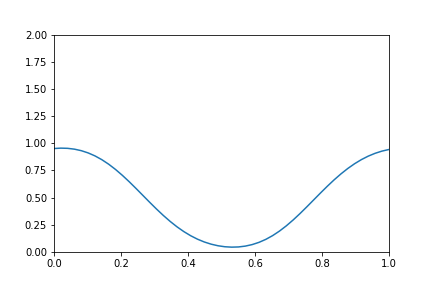
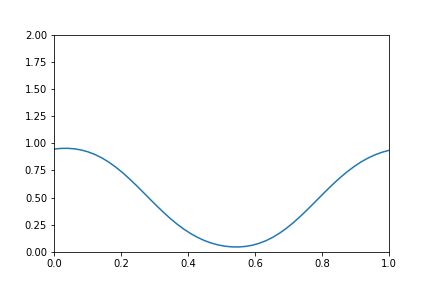
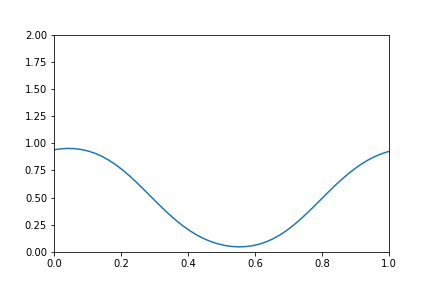
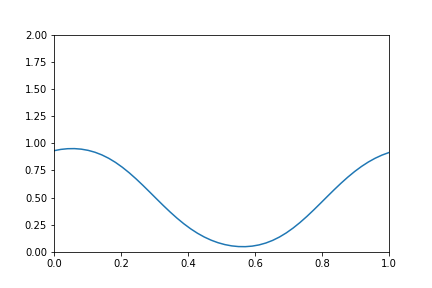
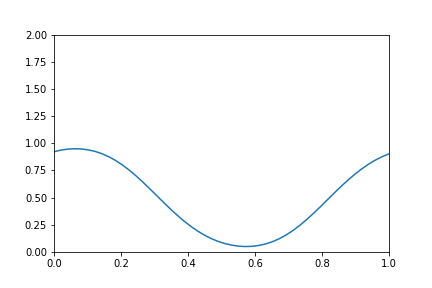
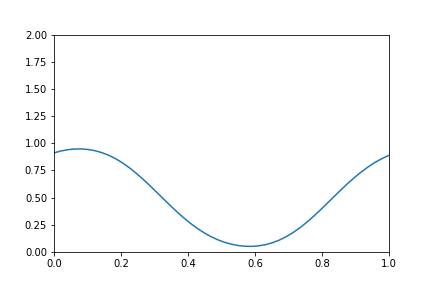
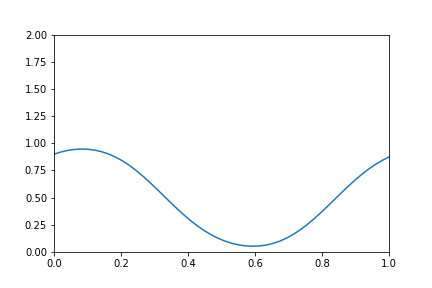
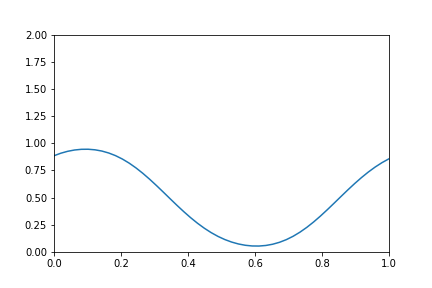
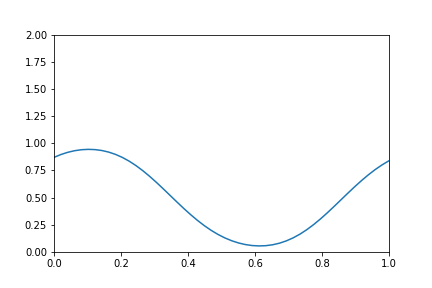
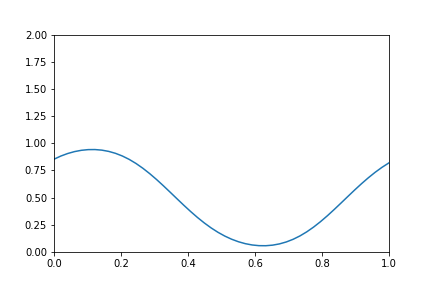
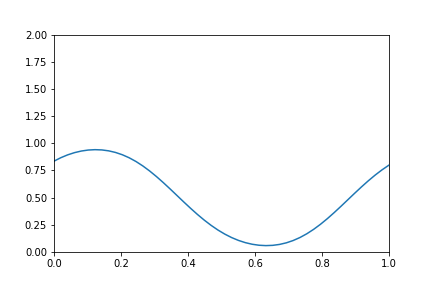
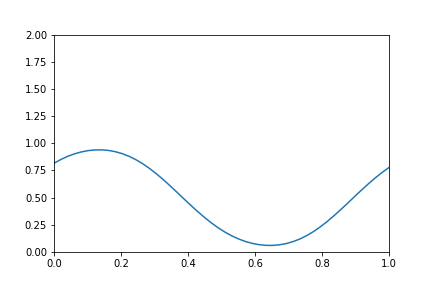
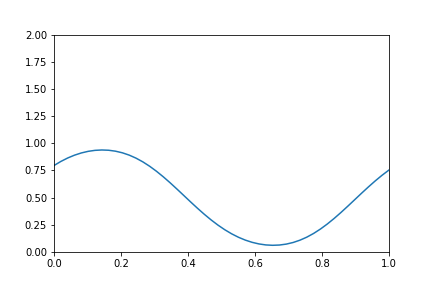
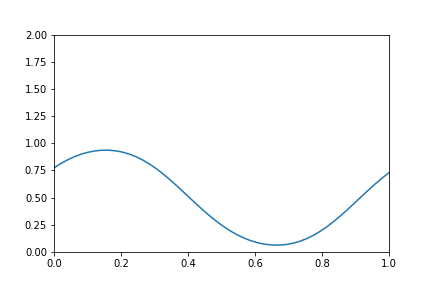
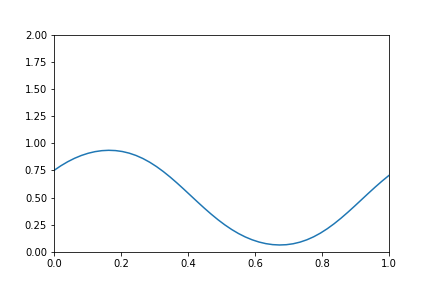
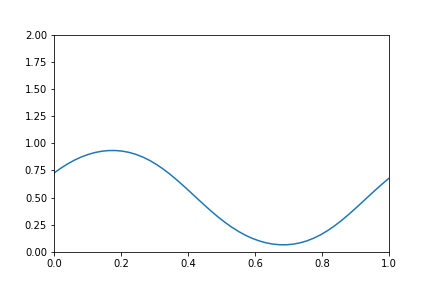
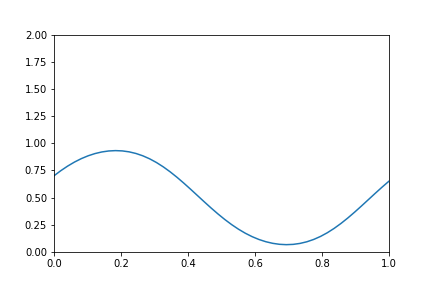
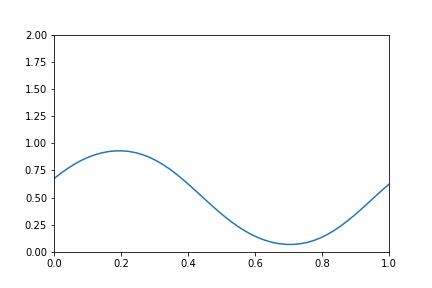
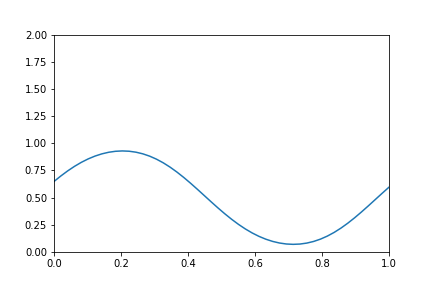
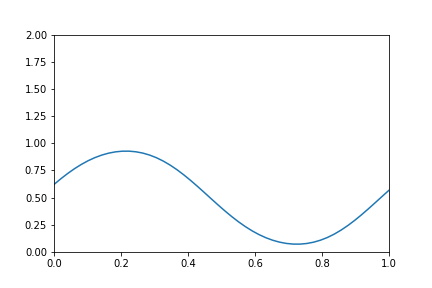
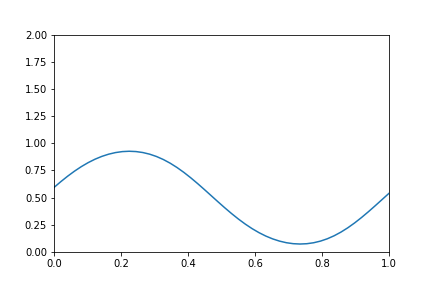

In [44]:
fig = plt.figure()
line, = plt.plot(x,uu[:,0])
plt.xlim(0,1)
plt.ylim(0,2)
skip = 1
def plot_frame(j):
    line.set_data(x,uu[:,skip*j]);
    
animation.FuncAnimation(fig,plot_frame,frames=int(uu.shape[1]/skip))

In [9]:
from scipy.optimize import fsolve

def RRK_pos_DIRK(rkm, dt, f, w0=[1.,0], t_final=1., relaxation=True, 
        rescale_step=True, debug=False, gammatol=10.1, print_gamma=False,
        one_step=False):
    """
    Relaxation Runge-Kutta method implementation.
    
    Options:
    
        rkm: Base Runge-Kutta method, in Nodepy format
        dt: time step size
        f: RHS of ODE system
        w0: Initial data
        t_final: final solution time
        relaxation: if True, use relaxation method.  Otherwise, use vanilla RK method.
        rescale_step: if True, new time step is t_n + \gamma dt
        debug: output some additional diagnostics
        gammatol: Fail if abs(1-gamma) exceeds this value
        
    """
    w = np.array(w0)
    t = 0
    # We pre-allocate extra space because if rescale_step==True then
    # we don't know exactly how many steps we will take.
    ww = np.zeros([len(w0),int((t_final-t)/dt*2.5)+10000])
    ww[:,0] = w.copy()
    tt = [t]
    ii = 0
    s = len(rkm)
    b = rkm.b
    y = np.zeros((s,len(w0)))
    max_gammam1 = 0.
    gams = []
    
    while t < t_final:
        if t + dt >= t_final:
            dt = t_final - t # Hit final time exactly
        
        for i in range(s):
            stageeq = lambda Y: (Y-w-dt*sum([rkm.A[i,j]*f(y[j,:]) for j in range(i)]) \
                                 - dt*rkm.A[i,i]*f(Y)).squeeze()
            nexty, info, ier, mesg = fsolve(stageeq,w,full_output=1)
            if ier != 1: print(mesg)
            y[i,:] = nexty.copy()
  
        F = np.array([f(y[i,:]) for i in range(s)])
        dw = dt*sum([b[j]*F[j] for j in range(s)])
        
        eps = 1.e-10
        gam = 1.
        if relaxation:
            wnp1 = w + dw
            neg = np.nonzero(wnp1<-eps)[0]
            if len(neg)>0:
                for ind in neg:
                    #print(ind,w[ind],dw[ind])
                    gam_ind = w[ind]/(w[ind]-wnp1[ind])
                    gam = min(gam, gam_ind)
            if gam!=1: print('gam: ',gam)
            w = w + gam*dw

        else:  # Use standard RK method
            w = w + dw
           
        if print_gamma:
            print(gam)
        
        if np.abs(gam-1.) > gammatol:
            print(gam)
            raise Exception("The time step is probably too large.")
        
        if gam == 0:
            raise Exception("gamma=0")
            
        if (t+dt < t_final) and rescale_step:
            t += gam*dt
        else:
            t += dt
        ii += 1
        tt.append(t)
        ww[:,ii] = w.copy()
        if debug:
            gm1 = np.abs(1.-gam)
            max_gammam1 = max(max_gammam1,gm1)
            gams.append(gam)
            
        if one_step:
            return w, gam
            
    if debug:
        print(max_gammam1)
        return tt, ww[:, :ii+1], np.array(gams)
    else:
        return tt, ww[:,:ii+1]

# Back to the heat equation
## Trapezoidal IRK without relaxation

-0.8773268250350335


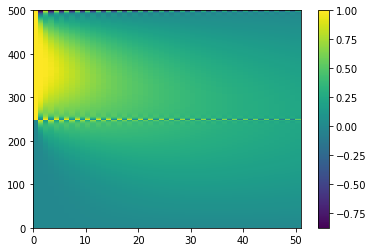

In [10]:
N=500
x = np.linspace(0,1,N)
dx = x[1]-x[0]

u0 = 1.*(x>0.5)
dt = 1.*dx

tt, uu = RRK_pos_DIRK(irk2,dt=dt,f=f_heat,w0=u0,t_final=0.1,relaxation=False)
print(np.min(uu))

plt.pcolor(uu[:,::1])
plt.colorbar()


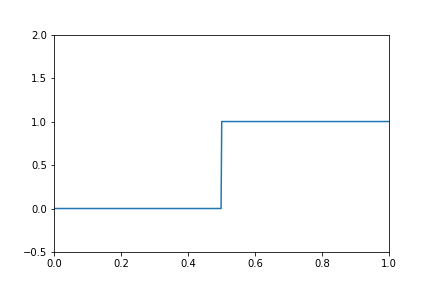
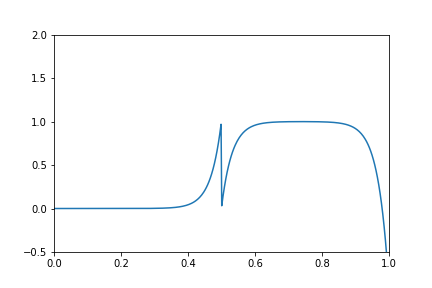
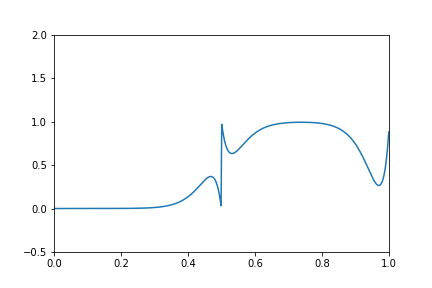
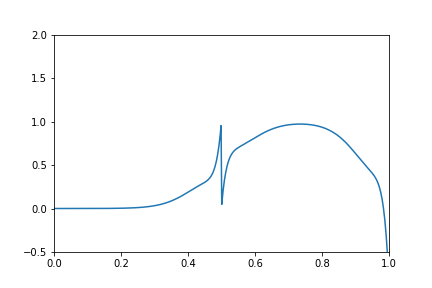
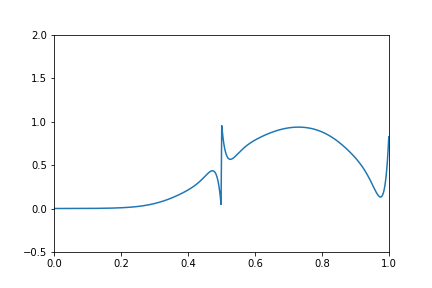
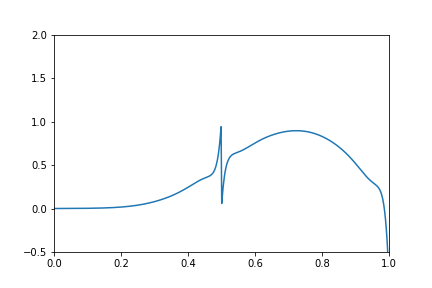
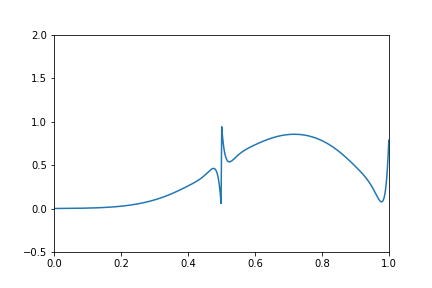
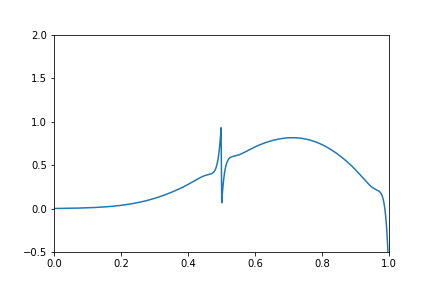
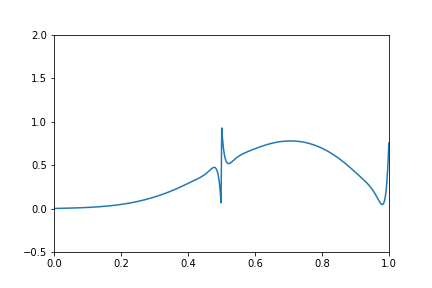
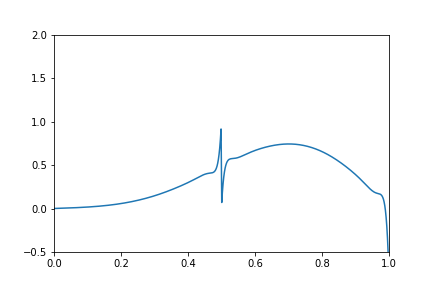
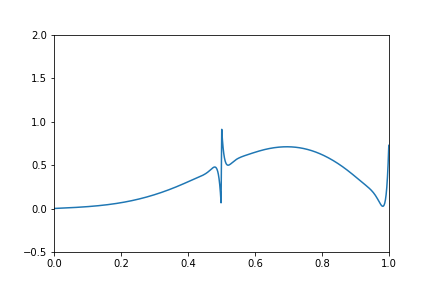
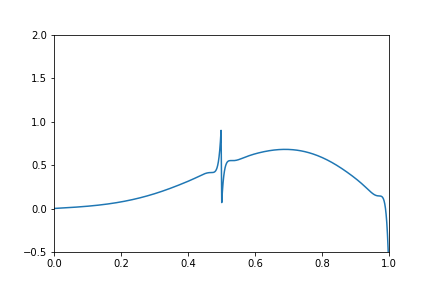
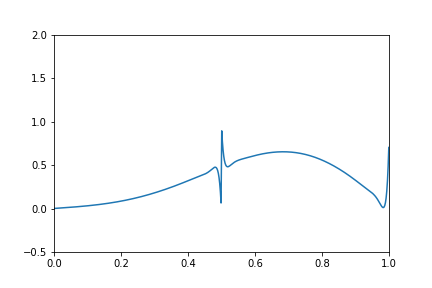
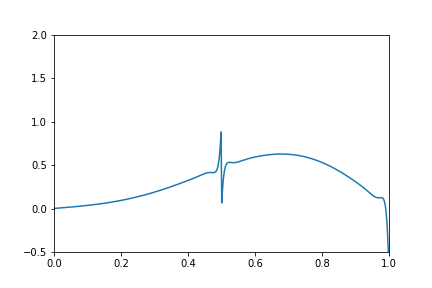
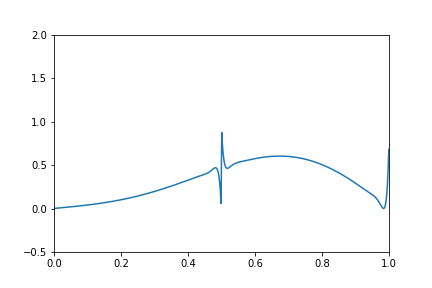
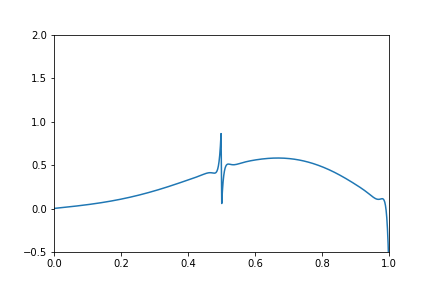
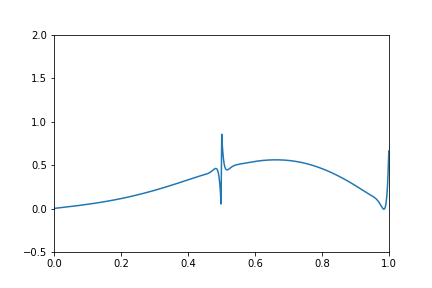
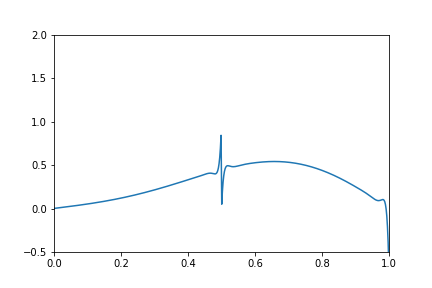
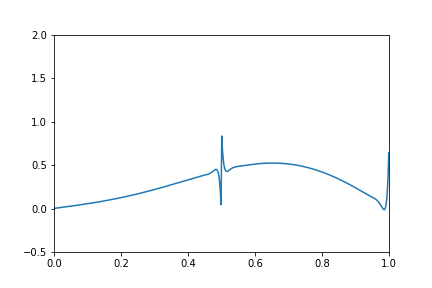
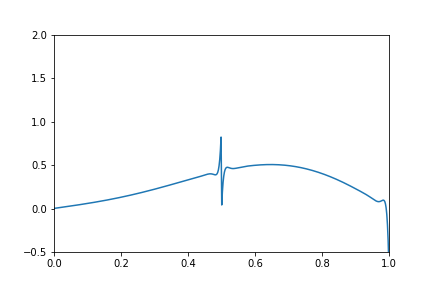
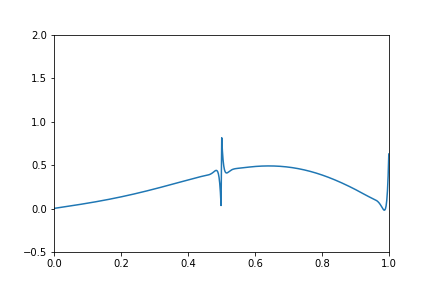
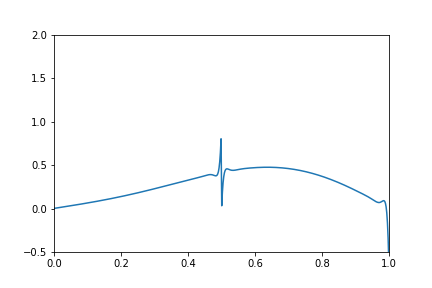
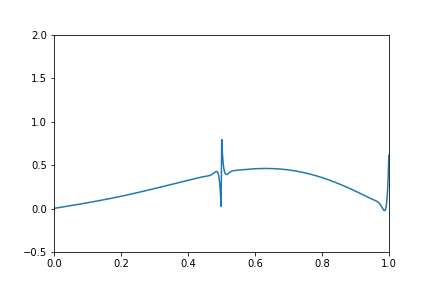
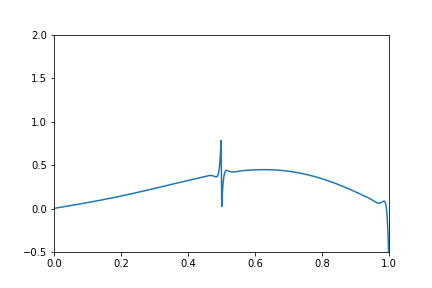
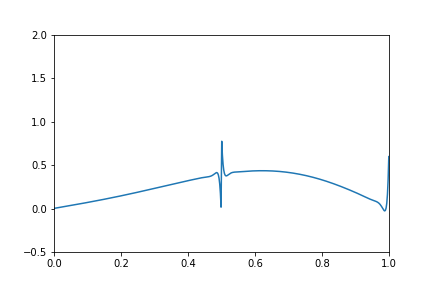
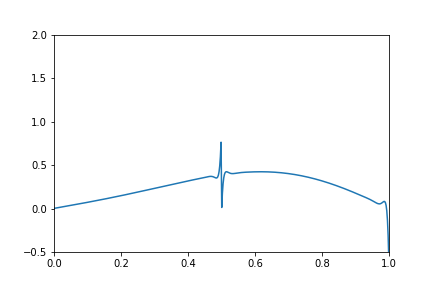
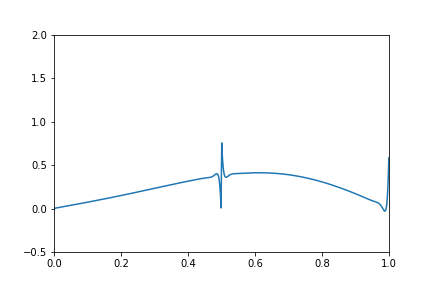
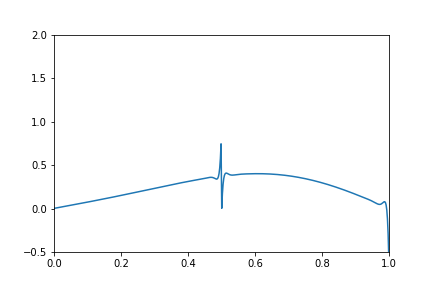
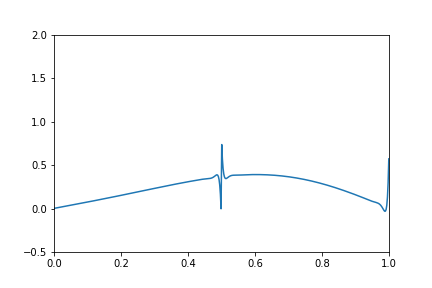
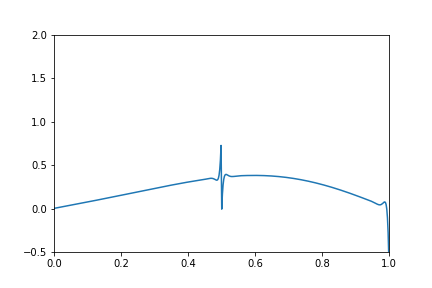
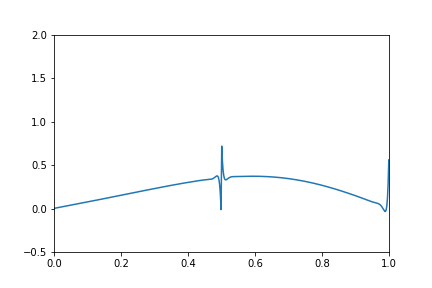
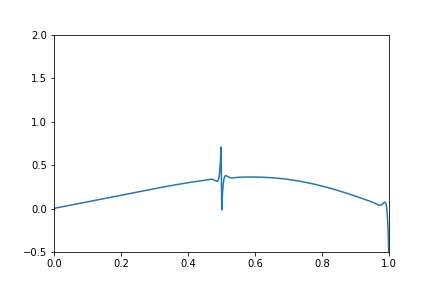
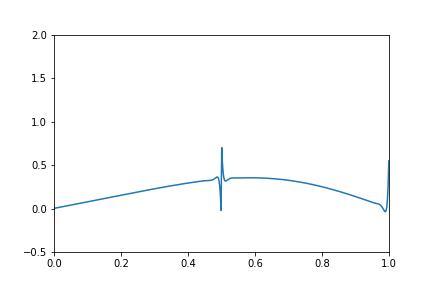
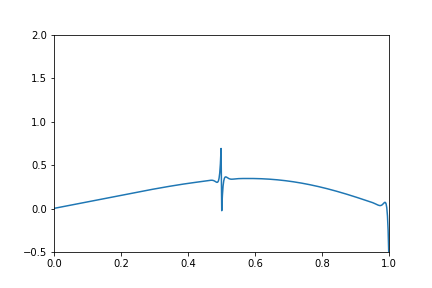
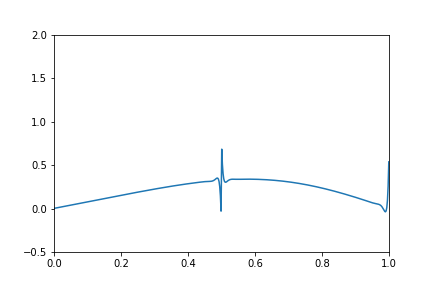
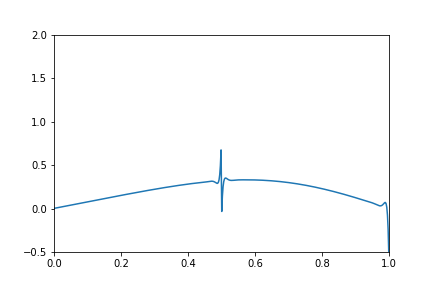
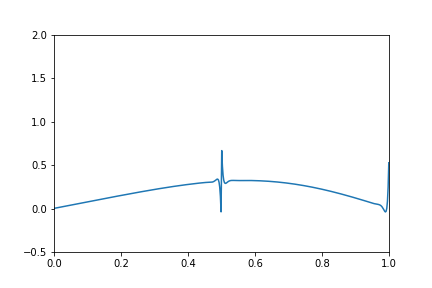
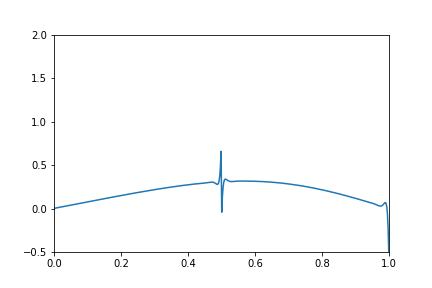
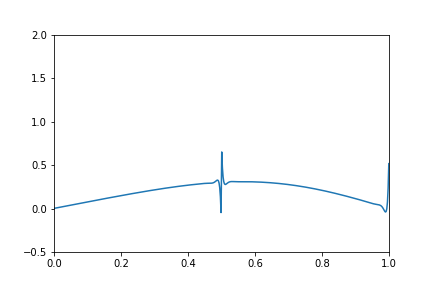
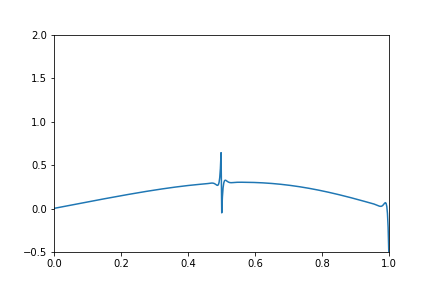
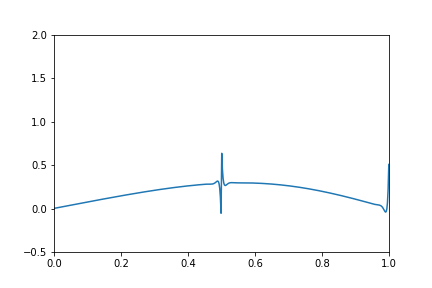
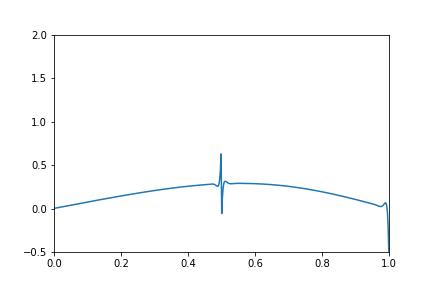
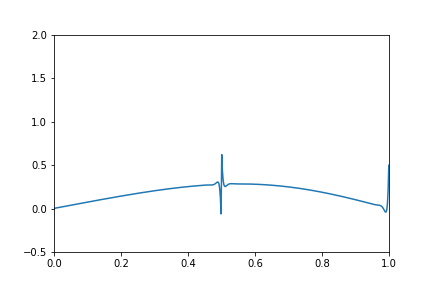
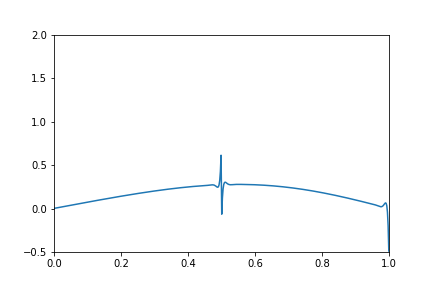
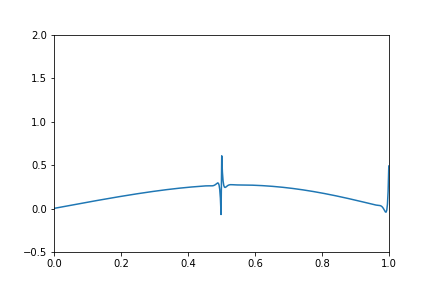
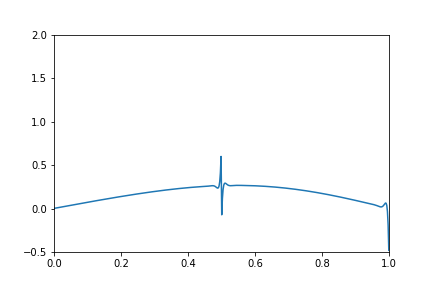
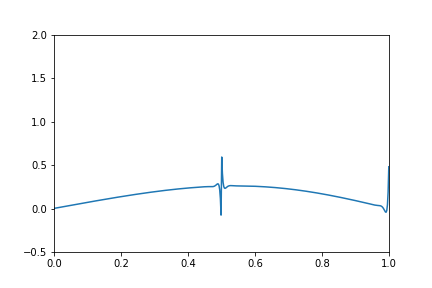
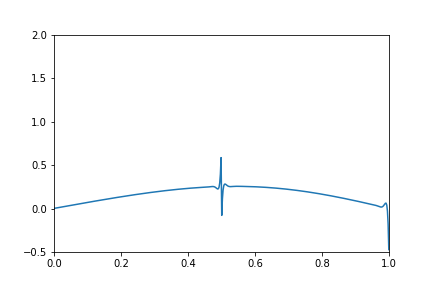
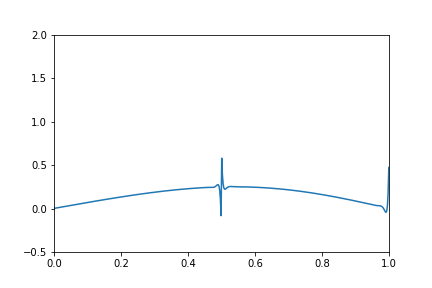
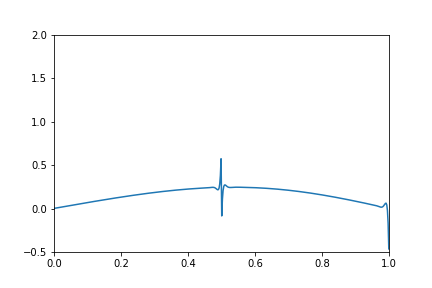
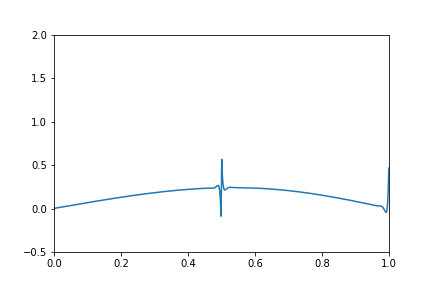

In [12]:
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display

fig = plt.figure()
line, = plt.plot([],[])
plt.ylim(-0.5,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,j]);
    
animation.FuncAnimation(fig,plot_frame,frames=uu.shape[1])

## Trapezoidal IRK with relaxation

gam:  0.5326723012021835
gam:  0.6962622639201546
gam:  0.8743968070598284
gam:  0.9172853792666812
gam:  0.9374501918993468
gam:  0.9472482741956787
gam:  0.9529266105726939
gam:  0.9568752185607542
gam:  0.9599906867974768
gam:  0.9626292198118943
gam:  0.9649467314958597
gam:  0.9670205916639893
gam:  0.9688949695420479
gam:  0.9705985866722513
gam:  0.972152086134587
gam:  0.9735713359330372
gam:  0.9748690753017621
gam:  0.976055848351151
gam:  0.9771406027639988
gam:  0.9781311080807353
gam:  0.979034260134982
gam:  0.979856303903938
gam:  0.9806029938274604
gam:  0.9812797053637503
gam:  0.9818915090138637
gam:  0.9824432163419133
0.0


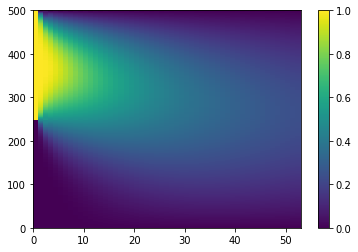

In [13]:
u0 = 1.*(x>0.5)
dt = 1.*dx

tt, uu = RRK_pos_DIRK(irk2,dt=dt,f=f_heat,w0=u0,t_final=0.1,relaxation=True)
print(np.min(uu))

plt.pcolor(uu[:,::1])
plt.colorbar()


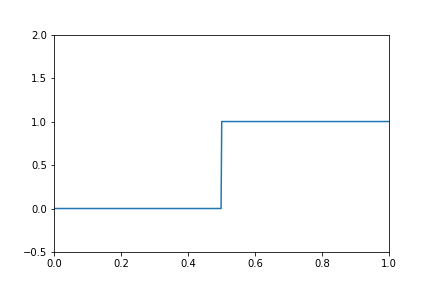
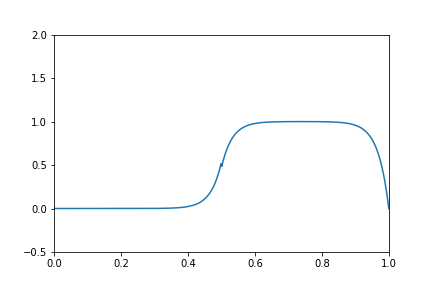
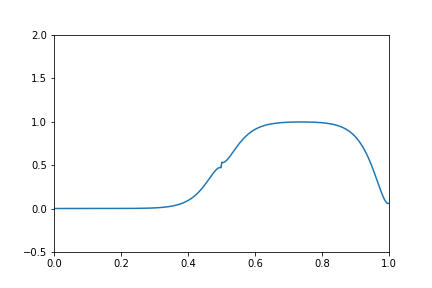
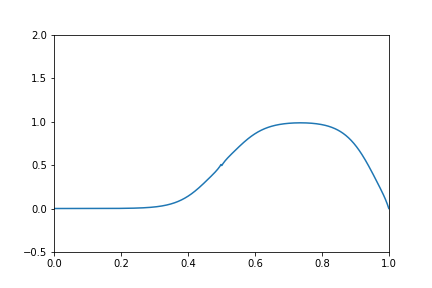
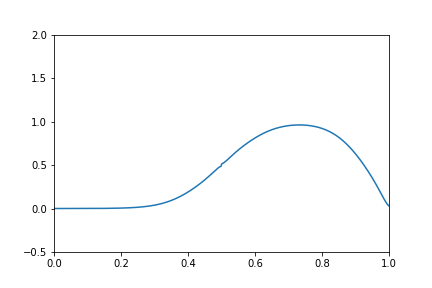
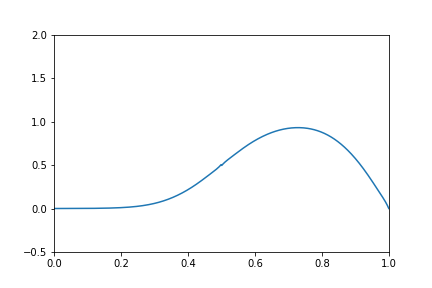
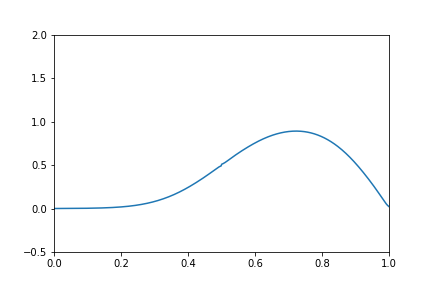
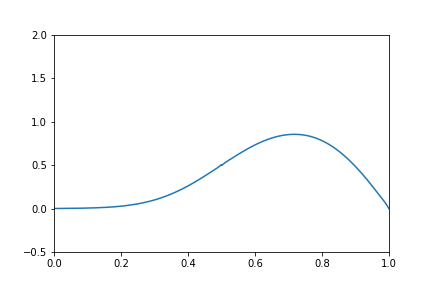
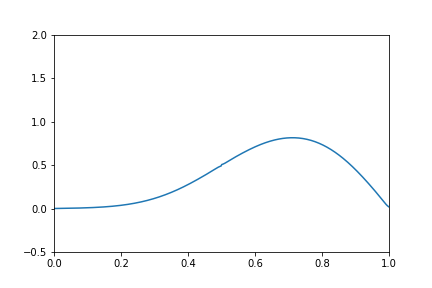
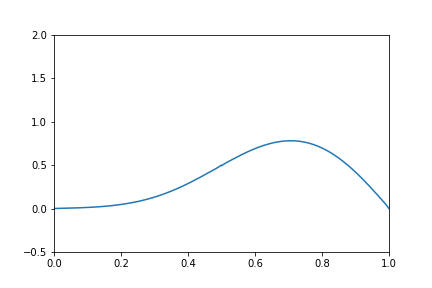
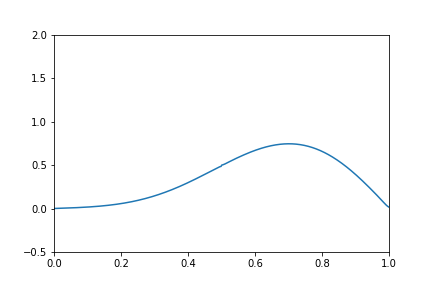
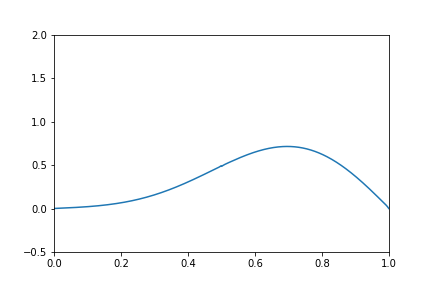
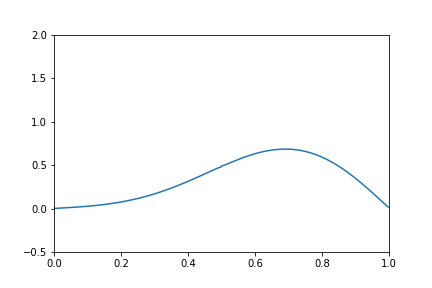
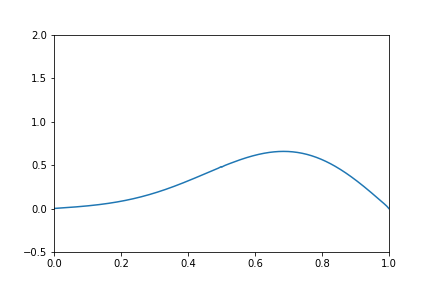
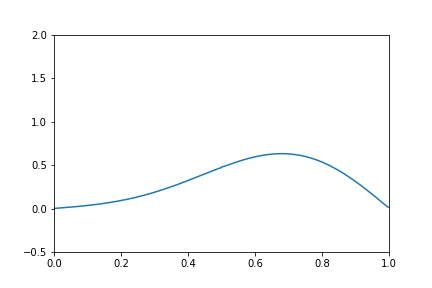
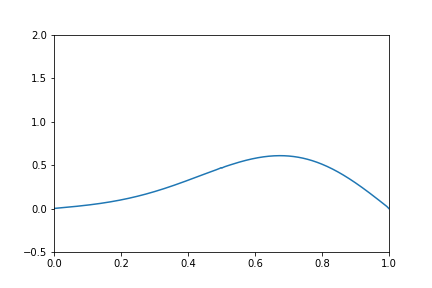
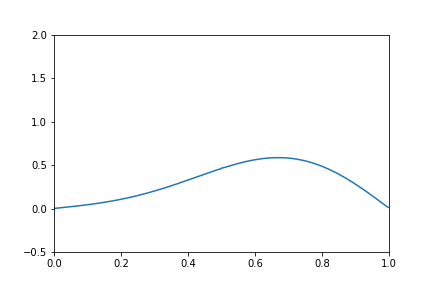
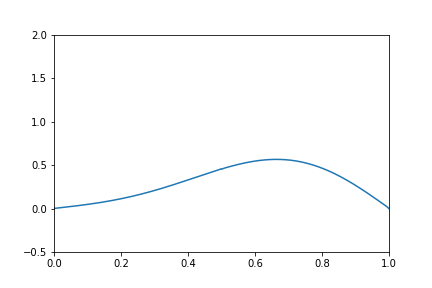
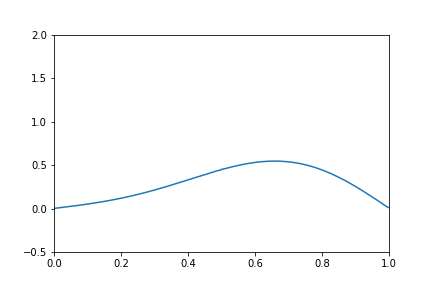
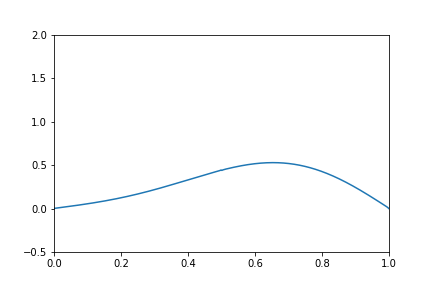
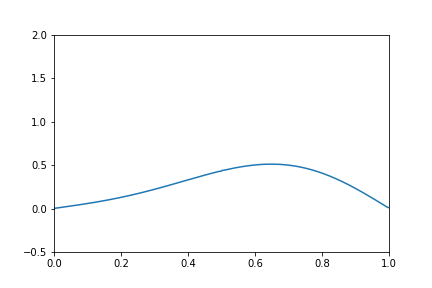
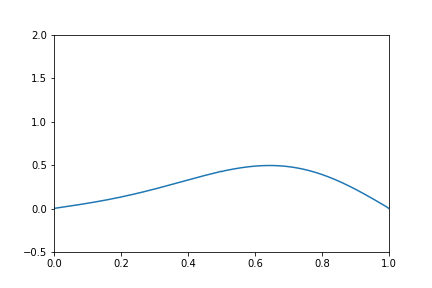
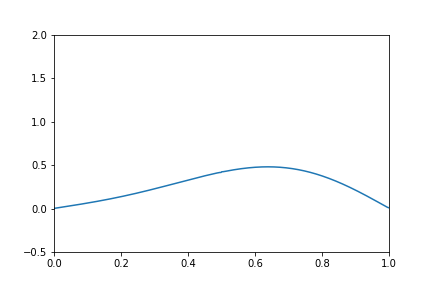
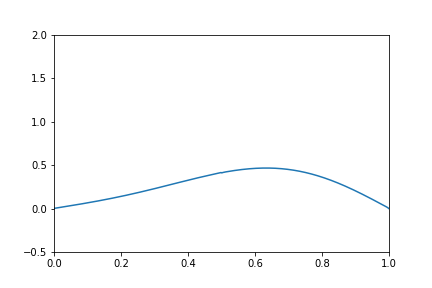
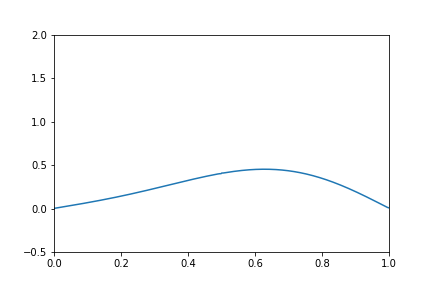
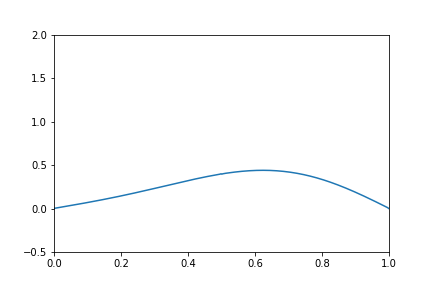
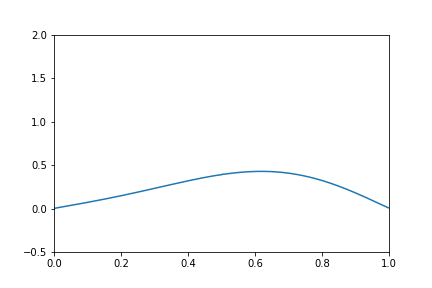
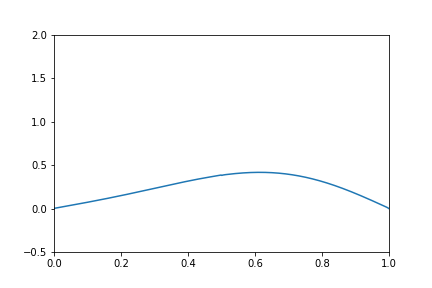
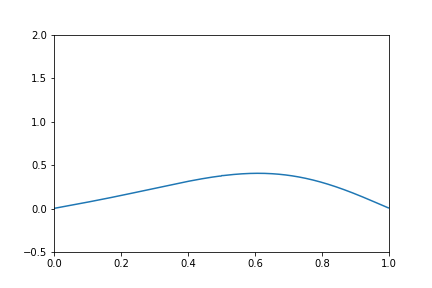
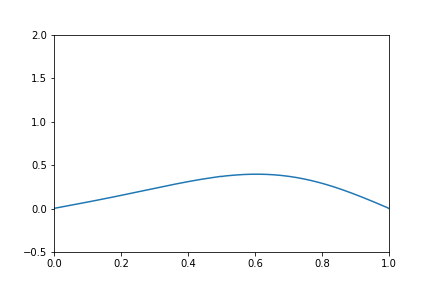
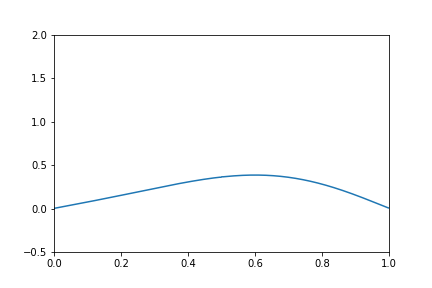
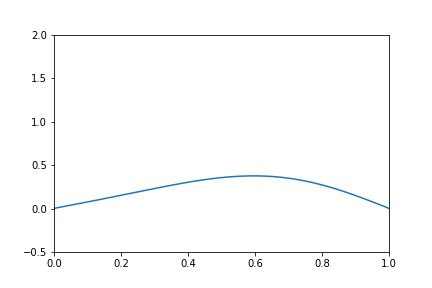
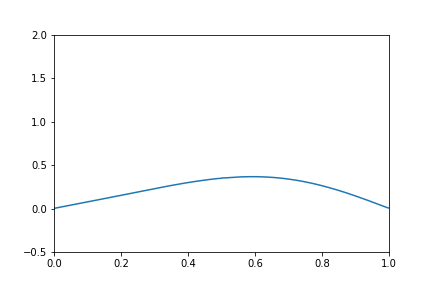
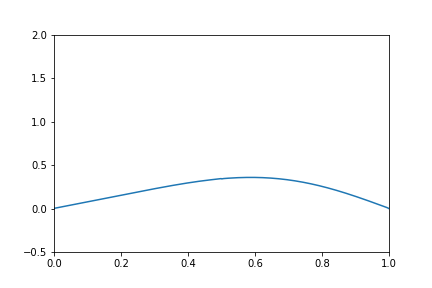
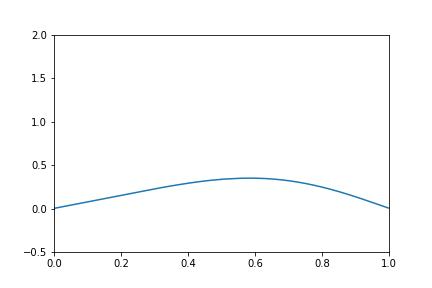
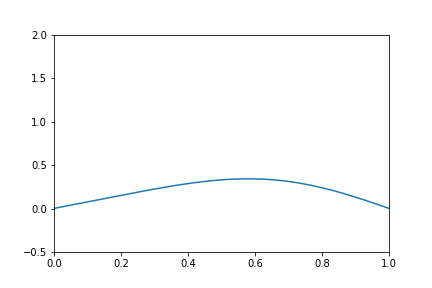
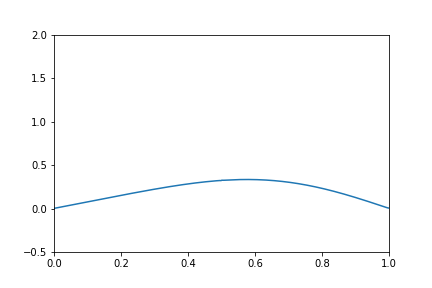
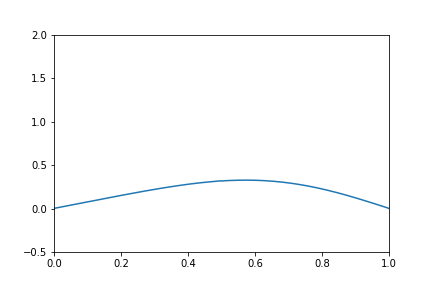
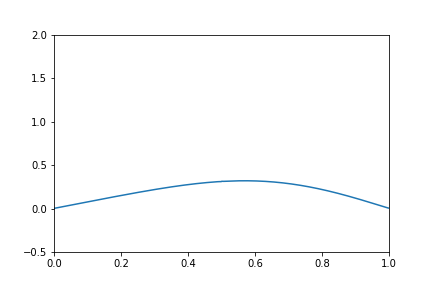
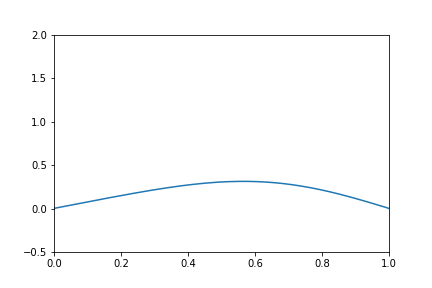
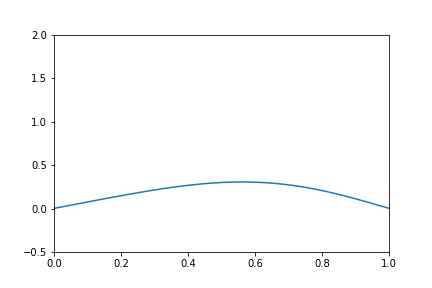
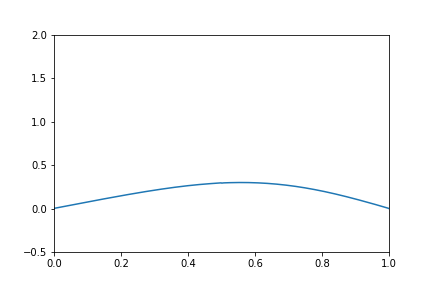
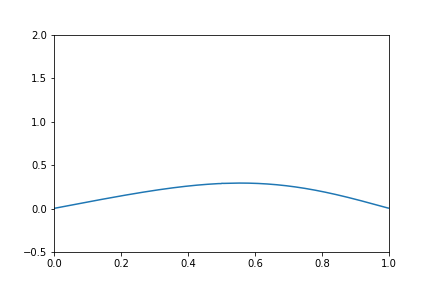
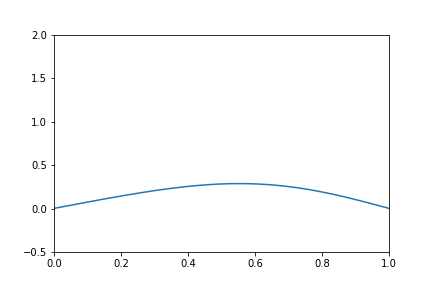
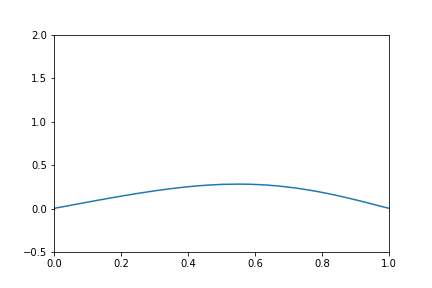
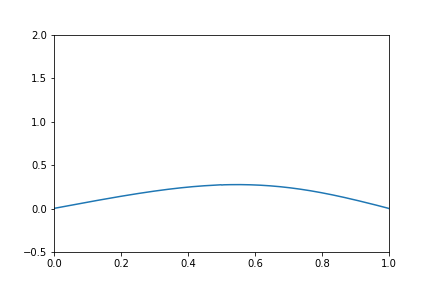
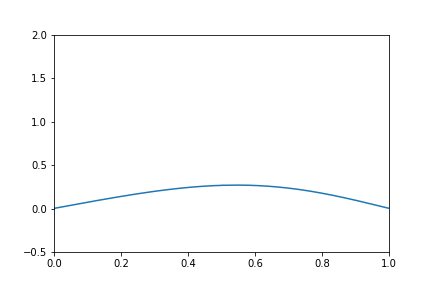
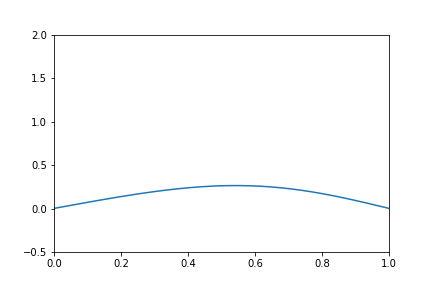
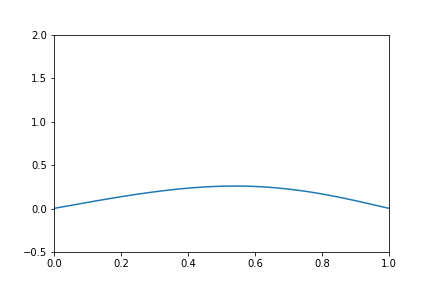
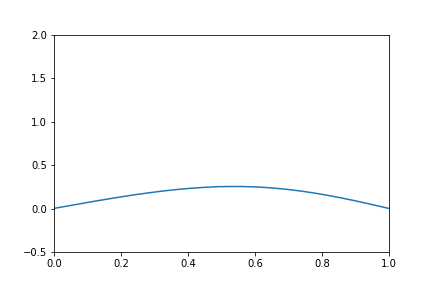
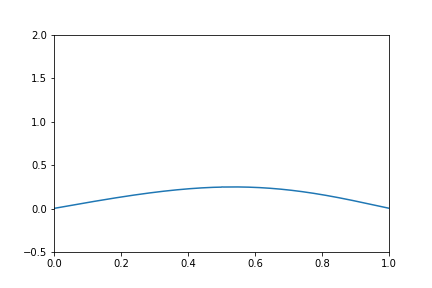
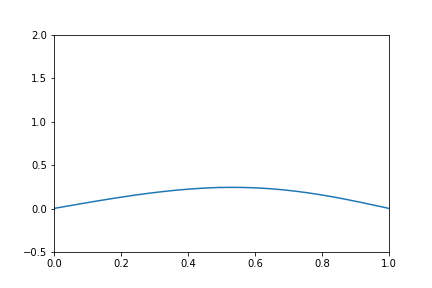
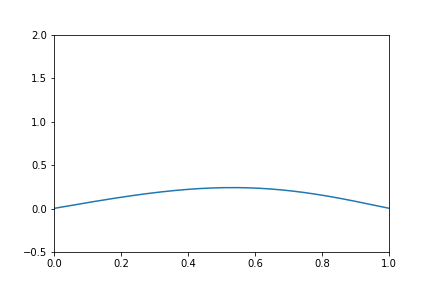

In [14]:
fig = plt.figure()
line, = plt.plot([],[])
plt.ylim(-0.5,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,j]);
    
animation.FuncAnimation(fig,plot_frame,frames=uu.shape[1])

## TR-BDF2 for reference

gam:  0.9816944684629766
0.0



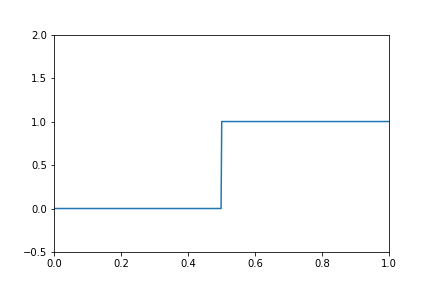
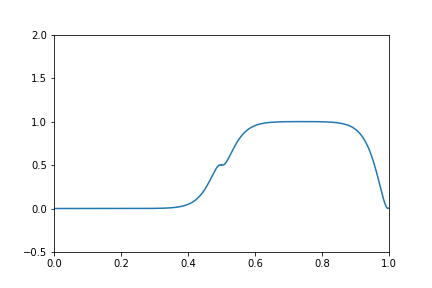
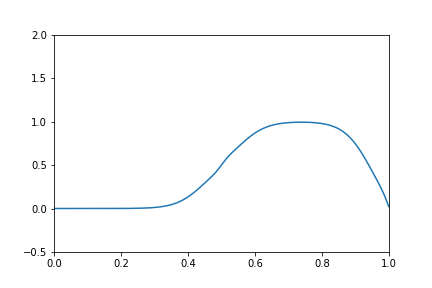
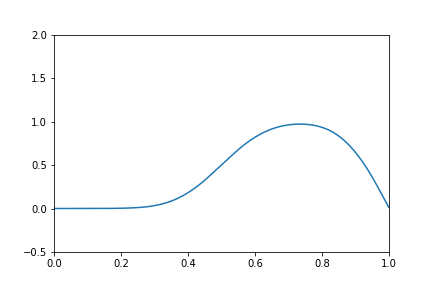
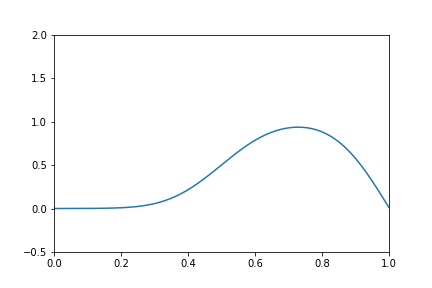
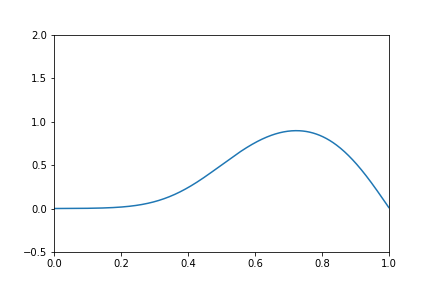
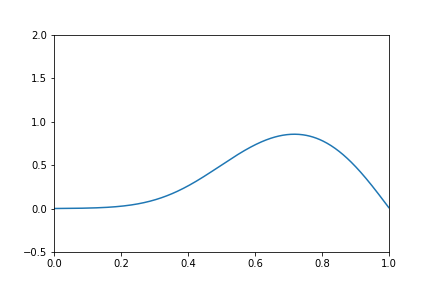
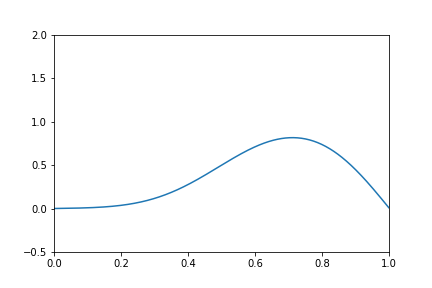
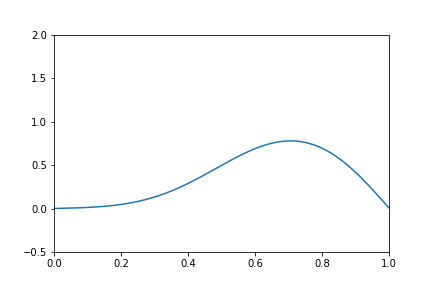
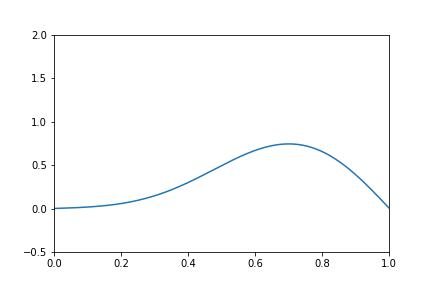
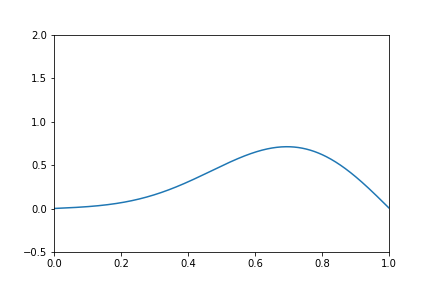
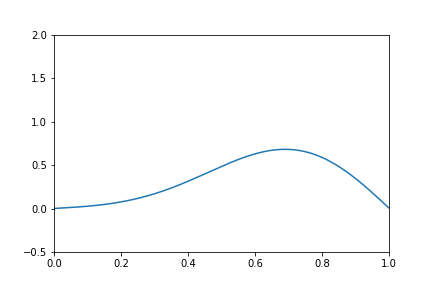
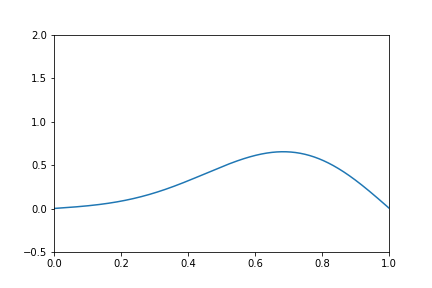
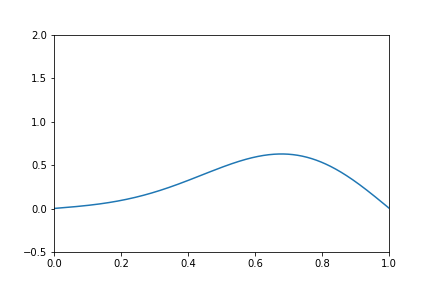
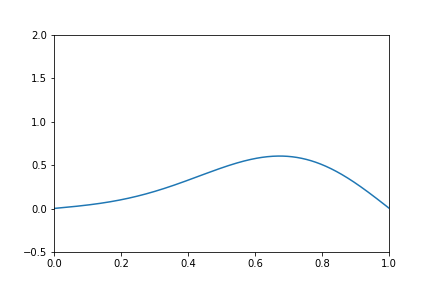
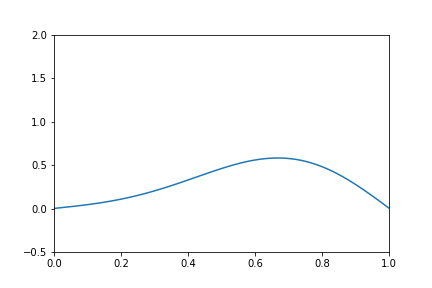
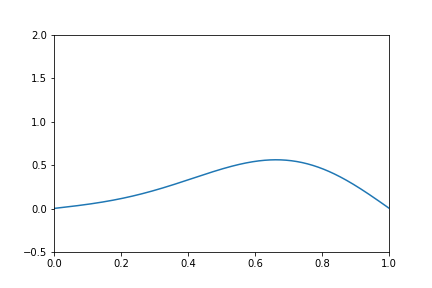
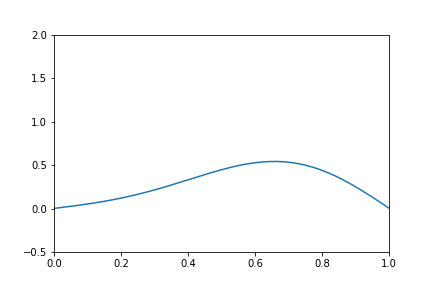
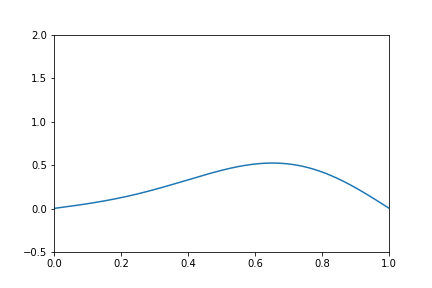
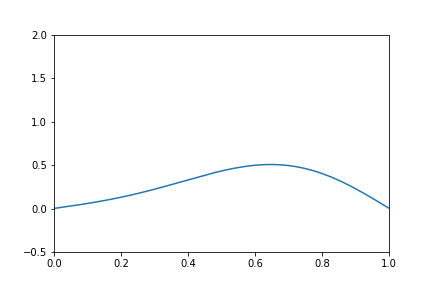
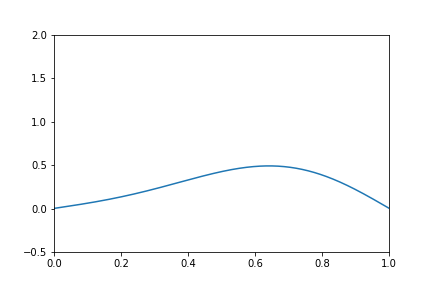
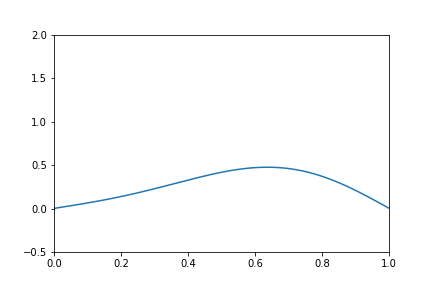
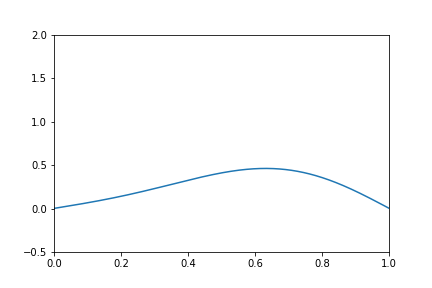
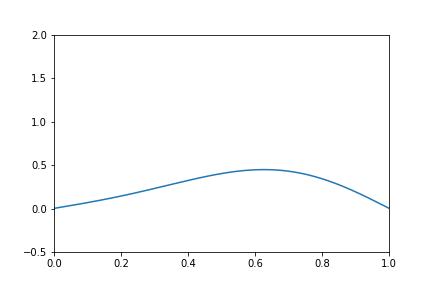
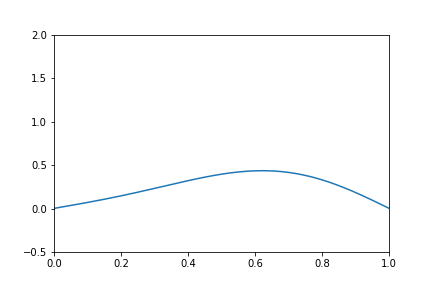
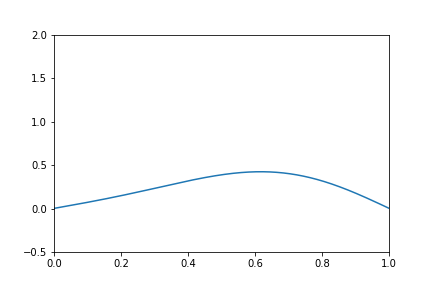
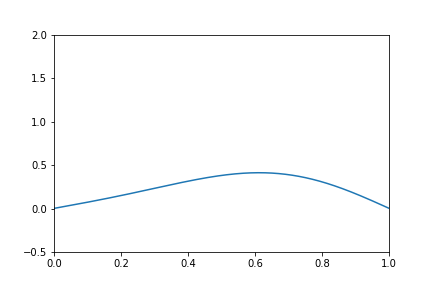
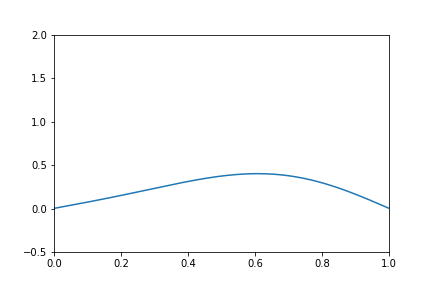
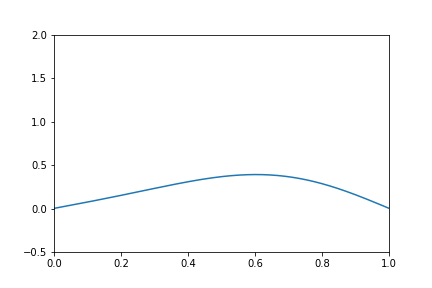
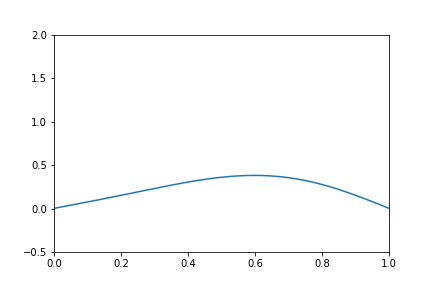
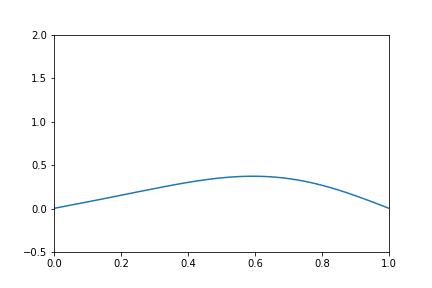
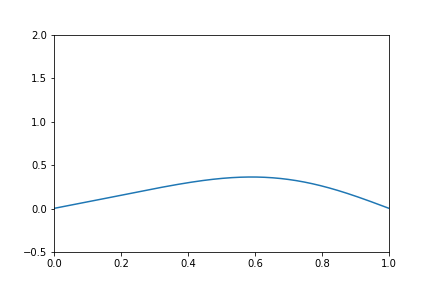
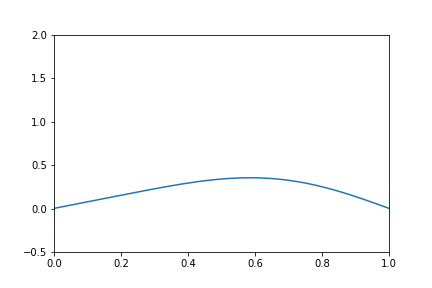
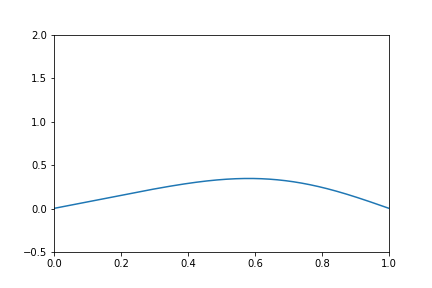
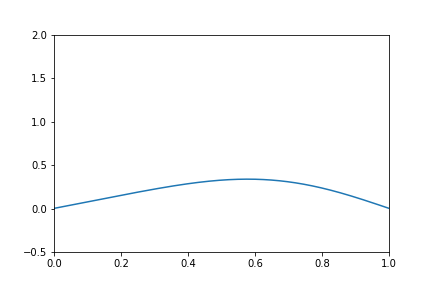
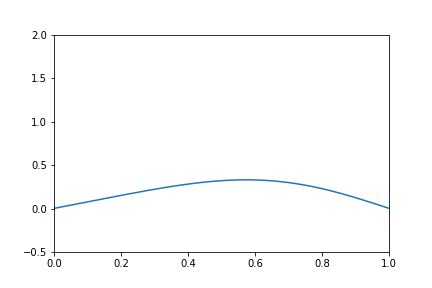
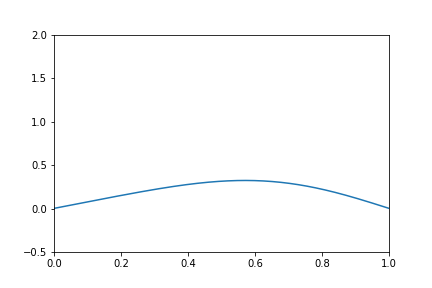
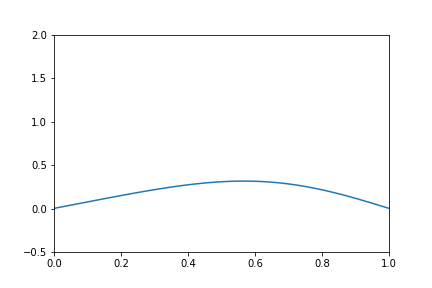
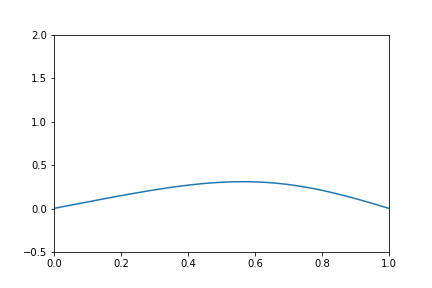
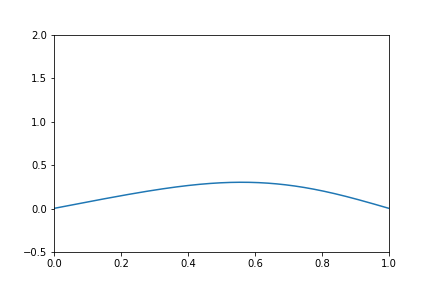
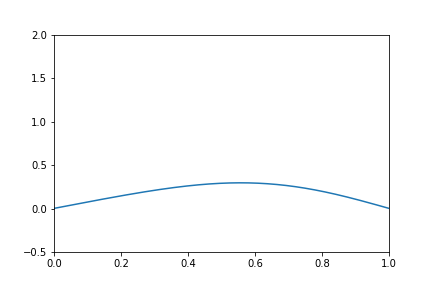
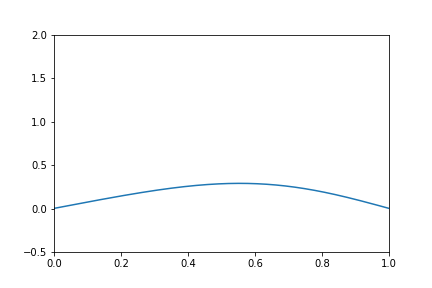
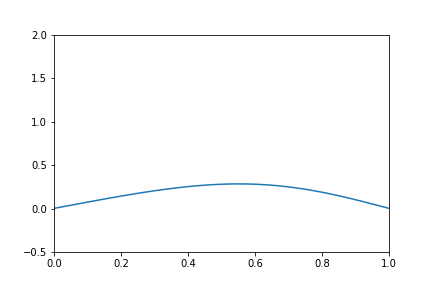
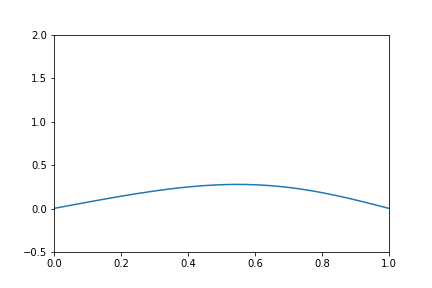
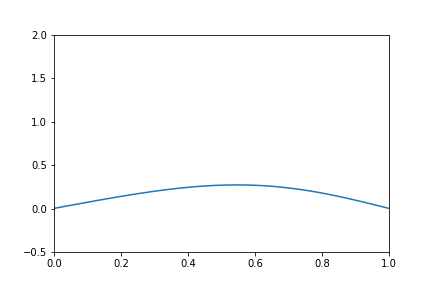
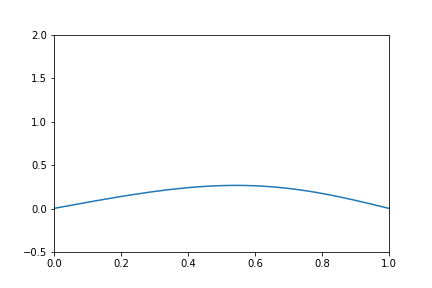
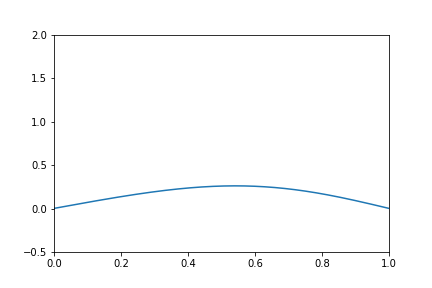
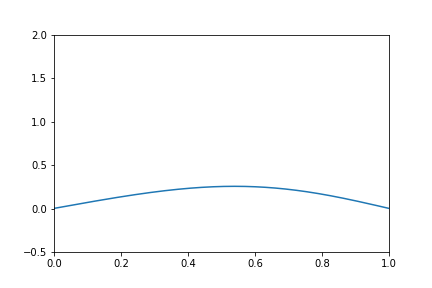
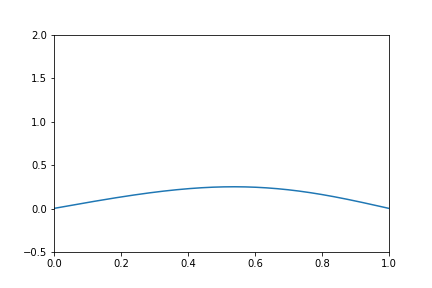
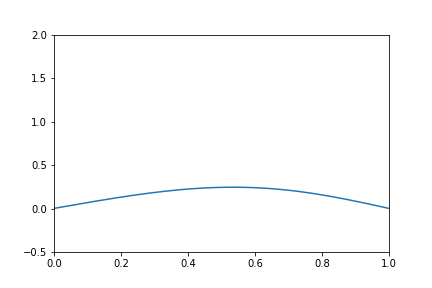
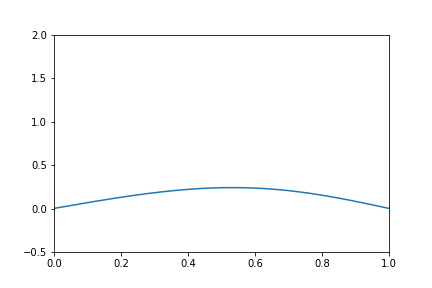

In [15]:
u0 = 1.*(x>0.5)
dt = 1.*dx

tt, uu = RRK_pos_DIRK(trbdf,dt=dt,f=f_heat,w0=u0,t_final=0.1,relaxation=True)
print(np.min(uu))

fig = plt.figure()
line, = plt.plot([],[])
plt.ylim(-0.5,2)
plt.xlim(0,1)

def plot_frame(j):
    line.set_data(x,uu[:,j]);
    
animation.FuncAnimation(fig,plot_frame,frames=uu.shape[1])

Add fully-discrete convergence results.

# Atmospheric pollution model

In [16]:
# Atmospheric pollution model from Hundsdorfer & Verwer

def k1(t):
    th = t/3600  # Time in hours
    thbar = th - 24*(th//24)
    if thbar>4 and thbar<20:
        sec = (np.sin(np.pi/16 *(thbar-4)))**0.2
        return 1.e-5*np.exp(7.*sec)
    else:
        return 1.e-40

k3 = 1.e-16
k2 = 1.e5
sigma2 = 1.e6

def f_pollution(u,t):
    du = np.zeros(4)
    du[0] = k1(t)*u[2] - k2*u[0]
    du[1] = k1(t)*u[2] - k3*u[1]*u[3] + sigma2
    du[2] = k3*u[1]*u[3]-k1(t)*u[2]
    du[3] = k2*u[0] - k3*u[1]*u[3]
    return du

In [17]:
from scipy.optimize import fsolve

def RRK_pos_DIRK_NA(rkm, dt, f, w0=[1.,0], t_final=1., relaxation=True, 
        rescale_step=True, debug=False, gammatol=10.1, print_gamma=False,
        one_step=False):
    """
    Relaxation Runge-Kutta method implementation.
    
    Options:
    
        rkm: Base Runge-Kutta method, in Nodepy format
        dt: time step size
        f: RHS of ODE system
        w0: Initial data
        t_final: final solution time
        relaxation: if True, use relaxation method.  Otherwise, use vanilla RK method.
        rescale_step: if True, new time step is t_n + \gamma dt
        debug: output some additional diagnostics
        gammatol: Fail if abs(1-gamma) exceeds this value
        
    """
    w = np.array(w0)
    t = 0
    # We pre-allocate extra space because if rescale_step==True then
    # we don't know exactly how many steps we will take.
    ww = np.zeros([len(w0),int((t_final-t)/dt*2.5)+10000])
    ww[:,0] = w.copy()
    tt = [t]
    ii = 0
    s = len(rkm)
    b = rkm.b
    c = rkm.c
    y = np.zeros((s,len(w0)))
    max_gammam1 = 0.
    gams = []
    
    while t < t_final:
        if t + dt >= t_final:
            dt = t_final - t # Hit final time exactly
        
        for i in range(s):
            stageeq = lambda Y: (Y-w-dt*sum([rkm.A[i,j]*f(y[j,:],t+c[j]*dt) for j in range(i)]) \
                                 - dt*rkm.A[i,i]*f(Y,t+c[i]*dt)).squeeze()
            nexty, info, ier, mesg = fsolve(stageeq,w,full_output=1)
            if ier != 1: print(mesg)
            y[i,:] = nexty.copy()
  
        F = np.array([f(y[i,:],t+c[i]*dt) for i in range(s)])
        dw = dt*sum([b[j]*F[j] for j in range(s)])
        
        eps = 1.e-10
        gam = 1.
        if relaxation:
            wnp1 = w + dw
            neg = np.nonzero(wnp1<-eps)[0]
            if len(neg)>0:
                for ind in neg:
                    #print(ind,w[ind],dw[ind])
                    gam_ind = w[ind]/(w[ind]-wnp1[ind])
                    gam = min(gam, gam_ind)
            if gam!=1: print('gam: ',gam)
            w = w + gam*dw

        else:  # Use standard RK method
            w = w + dw
           
        if print_gamma:
            print(gam)
        
        if np.abs(gam-1.) > gammatol:
            print(gam)
            raise Exception("The time step is probably too large.")
        
        if (t+dt < t_final) and rescale_step:
            t += gam*dt
        else:
            t += dt
        ii += 1
        tt.append(t)
        ww[:,ii] = w.copy()
        if debug:
            gm1 = np.abs(1.-gam)
            max_gammam1 = max(max_gammam1,gm1)
            gams.append(gam)
            
        if one_step:
            return w, gam
            
    if debug:
        print(max_gammam1)
        return tt, ww[:, :ii+1], np.array(gams)
    else:
        return tt, ww[:,:ii+1]

In [18]:
t_final = 3600*24*6
dt = 3600

tref, uref = RRK_pos_DIRK_NA(trbdf,dt=dt/128,f=f_pollution,w0=u0,
                             t_final=t_final,relaxation=False)
plt.plot(np.array(tref)/3600/24,uref[0,:],'-k');
plt.xlim(0,6);

ValueError: operands could not be broadcast together with shapes (500,) (4,) 

In [ ]:
u0 = np.array([0,1.3e8,5.e11,8.e11])

tt, uu = RRK_pos_DIRK_NA(irk2,dt=dt,f=f_pollution,w0=u0,t_final=t_final,relaxation=False)
plt.plot(np.array(tref)/3600/24,uref[0,:],'-k');
plt.plot(np.array(tt)/3600/24,uu[0,:]);
plt.xlim(0,6);
plt.title('Trapezoidal without relaxation');
skip = int((len(uref[0,:])-1)/(len(uu[0,:])-1))
error = dt*np.sum(np.abs(uu[0,:]-uref[0,::skip]))
print(error/1.e6)

In [ ]:
u0 = np.array([0,1.3e8,5.e11,8.e11])

def solve_pollution(rkm,dt,relax=True):
    tt, uu = RRK_pos_DIRK_NA(rkm,dt=dt,f=f_pollution,w0=u0,t_final=t_final,relaxation=relax)
    plt.plot(np.array(tref)/3600/24,uref[0,:],'-k');
    plt.plot(np.array(tt)/3600/24,uu[0,:]);
    plt.xlim(0,6);
    if relax:
        plt.title(rkm.shortname+' with relaxation');
    else:
        plt.title(rkm.shortname+' without relaxation');
    skip = int((len(uref[0,:])-1)/(len(uu[0,:])-1))
    error = dt*np.sum(np.abs(uu[0,:]-uref[0,::skip]))
    print(error/1.e6)
    
solve_pollution(irk2,dt,relax=False)

In [ ]:
solve_pollution(irk2,dt,relax=True)

In [ ]:
solve_pollution(trbdf,dt,relax=True)

In [ ]:
solve_pollution(be,dt,relax=True)

In [ ]:
solve_pollution(be,dt/16,relax=True)